# 0.0 IMPORTS

## 0.1 Libraries

In [ ]:
#!pip install shap

In [1]:
import random
import bisect
import warnings

import numpy        as np
import pandas       as pd
import scipy.stats  as ss

import seaborn           as sns
from matplotlib          import pyplot as plt
from matplotlib.gridspec import GridSpec

from IPython.display         import Image
from IPython.core.display    import HTML

from imblearn                import combine        as c

from pandas_profiling        import ProfileReport

from sklearn.metrics         import (accuracy_score, roc_auc_score, average_precision_score, precision_score,
                                    recall_score, f1_score, cohen_kappa_score, balanced_accuracy_score, classification_report)
from sklearn.ensemble        import RandomForestClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.preprocessing   import OneHotEncoder
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split, StratifiedKFold

from xgboost                 import XGBClassifier
from lightgbm                import LGBMClassifier
from catboost                import CatBoostClassifier


from boruta                  import BorutaPy

from scikitplot.metrics      import plot_confusion_matrix


import sys
sys.path.append('../')
## My Functions
from modules.postgres import Postgres

## 0.2 Helper Functions

### 0.2.1 Notebook Config

In [2]:
def jupyter_settings():
    %matplotlib inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML('<style>.container { width:85% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    warnings.filterwarnings("ignore")
    
    sns.set()

In [3]:
jupyter_settings()

### 0.2.2 Functions

In [4]:
def statistical_summary(num_attributes):
    ### Central Tendency -> Mean, Median, Mode
    ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
    ct2 = pd.DataFrame(num_attributes.apply(np.median)).T
    ct3 = pd.DataFrame(ss.mode(num_attributes)[0])
    ct3.columns = ct1.columns

    ### Dispersion -> std, min, max, range, skew, kurtosis, rsd
    d1 = pd.DataFrame(num_attributes.apply(np.std)).T
    d2 = pd.DataFrame(num_attributes.apply(min)).T
    d3 = pd.DataFrame(num_attributes.apply(max)).T
    d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T
    d7 = d1 / ct1
    
    # Quantile
    q05 = pd.DataFrame(num_attributes.quantile(0.05)).T
    q10 = pd.DataFrame(num_attributes.quantile(0.10)).T
    q25 = pd.DataFrame(num_attributes.quantile(0.25)).T
    q75 = pd.DataFrame(num_attributes.quantile(0.75)).T
    q90 = pd.DataFrame(num_attributes.quantile(0.90)).T
    q95 = pd.DataFrame(num_attributes.quantile(0.95)).T

    # Concatenate
    m = pd.concat([d2, d3, d4, ct3, ct1, ct2, q05, q10, q25, q75, q90, q95, d1, d7, d5, d6]).T.reset_index()
    m.columns = ['Attributes', 'Min', 'Max', 'Range', 'Mode', 'Mean', 'Median', '5%', '10%', '25%', '75%', '90%', '95%', 'Std','Relative Std', 'Skew', 'Kurtosis']
    
    return m




def cramer_v(x, y):
    cm = pd.crosstab(x, y).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))




def age_stage(num, breakpoints=[10, 20, 30, 45, 60, 70, 80, 120], result='01234567'):
    i = bisect.bisect(breakpoints, num-1)
    age_mapping = {
        0: 'Child',
        1: 'Teenager',
        2: 'Young',
        3: 'Adult',
        4: 'Midlife',
        5: 'Senior',
        6: 'Mature Adulthood',
        7: 'Late Adulthood'
    }
    return age_mapping[i]



def ml_scores(model_name, y, yhat, yhat_proba):
    precision = precision_score(y, yhat)
    recall = recall_score(y, yhat)
    f1 = f1_score(y, yhat)
    kappa = cohen_kappa_score(y, yhat)
    balanced_accuracy = balanced_accuracy_score(y, yhat)
    ap = average_precision_score(y, yhat_proba)
    roc_auc = roc_auc_score(y, yhat_proba)
    
    return pd.DataFrame({ 'Model Name': model_name, 
                       'Precision': precision, 
                       'Recall': recall,
                       'F1 Score': f1,
                       'Kappa': kappa,
                       'Balanced Accuracy': balanced_accuracy,
                       'Average Precision Score': ap,
                       'ROC AUC': roc_auc}, index=[0])
    

    
def cross_validation(X_train, y_train, model_name, model, num_folds=5, verbose=True):
    # k-fold generate
    num_folds = num_folds
    kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
    
    precision_acc_list = []
    recall_acc_list = []
    f1_acc_list = []
    kappa_acc_list = []
    balanced_acc_list = []
    ap_acc_list = []
    roc_auc_acc_list = []

    i = 1
    for train_ix, val_ix in kfold.split(X_train, y_train):
        if verbose:
            print('Fold Number: {}/{}'.format(i, num_folds))
        # get fold
        X_train_fold = X_train.iloc[train_ix]
        y_train_fold = y_train.iloc[train_ix]

        X_val_fold = X_train.iloc[val_ix]
        y_val_fold = y_train.iloc[val_ix]

        # training model
        model.fit(X_train_fold, y_train_fold)

        # prediction
        yhat = model.predict(X_val_fold)
        yhat_proba = model.predict_proba(X_val_fold)[:,1]

        # metrics
        model_result = ml_scores(model_name, y_val_fold, yhat, yhat_proba)
        
        #Store Performance of each KFold iteration
        precision_acc_list.append(model_result['Precision'].tolist())
        recall_acc_list.append(model_result['Recall'].tolist())
        f1_acc_list.append(model_result['F1 Score'].tolist())
        kappa_acc_list.append(model_result['Kappa'].tolist())
        balanced_acc_list.append(model_result['Balanced Accuracy'].tolist())
        ap_acc_list.append(model_result['Average Precision Score'].tolist())
        roc_auc_acc_list.append(model_result['ROC AUC'].tolist())
        
        i += 1
        
    dict_result = {
                    'Model Name': [model_name],
                    'Precision CV': [np.round(np.mean(precision_acc_list),4).astype(str) + ' +/- ' + np.round(np.std(precision_acc_list),4).astype(str)],
                    'Recall CV': [np.round(np.mean(recall_acc_list),4).astype(str) + ' +/- ' + np.round(np.std(recall_acc_list),4).astype(str)],
                    'F1 Score CV': [np.round(np.mean(f1_acc_list),4).astype(str) + ' +/- ' + np.round(np.std(f1_acc_list),4).astype(str)],
                    'Kappa CV': [np.round(np.mean(kappa_acc_list),4).astype(str) + ' +/- ' + np.round(np.std(kappa_acc_list),4).astype(str)],
                    'Balanced Accuracy': [np.round(np.mean(balanced_acc_list),4).astype(str) + ' +/- ' + np.round(np.std(balanced_acc_list),4).astype(str)],
                    'Average Precision Score CV': [np.round(np.mean(ap_acc_list),4).astype(str) + ' +/- ' + np.round(np.std(ap_acc_list),4).astype(str)],
                    'ROC AUC CV': [np.round(np.mean(roc_auc_acc_list),4).astype(str) + ' +/- ' + np.round(np.std(roc_auc_acc_list),4).astype(str)]
                }

    return pd.DataFrame(dict_result)

## 0.3 Loading data

In [5]:
# class instantiation
pg = Postgres()

# schemas and tables
schema = pg.inspect_schema()
schema

{'pa004': ['users', 'vehicle', 'insurance']}

In [6]:
# query table
dict_tables = pg.get_data()

### 0.3.1 Table Users

In [7]:
users = dict_tables['users']
users.head()

,id,gender,age,region_code,policy_sales_channel
0,1,Male,44,28.0,26.0
1,2,Male,76,3.0,26.0
2,3,Male,47,28.0,26.0
3,4,Male,21,11.0,152.0
4,5,Female,29,41.0,152.0


### 0.3.2 Table Vehicle

In [8]:
vehicle = dict_tables['vehicle']
vehicle.head()

,id,driving_license,vehicle_age,vehicle_damage
0,1,1,> 2 Years,Yes
1,2,1,1-2 Year,No
2,3,1,> 2 Years,Yes
3,4,1,< 1 Year,No
4,5,1,< 1 Year,No


### 0.3.3 Table Insurance

In [9]:
insurance = dict_tables['insurance']
insurance.head()

,id,previously_insured,annual_premium,vintage,response
0,1,0,40454.0,217,1
1,2,0,33536.0,183,0
2,3,0,38294.0,27,1
3,4,1,28619.0,203,0
4,5,1,27496.0,39,0


### 0.3.4 Merge Dataset

In [10]:
df_raw = pd.merge(users, vehicle, how="inner", on="id")
df_raw = pd.merge(df_raw, insurance, how="inner", on="id")

In [11]:
del users, vehicle, insurance

### 0.3.5 Saving Test Data

In [12]:
# Apply stratified sampling in order to keep target variable proportion in the train and test datasets
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df_raw, df_raw['response']):
    train_dataset = df_raw.loc[train_index].reset_index(drop=True)
    test_dataset = df_raw.loc[test_index].reset_index(drop=True)
    
# Convert to .Feather Data
#train_dataset.to_feather('../00-Data/train_dataset.feather')
#test_dataset.to_feather('../00-Data/test_dataset.feather')

### 0.3.6 Read Training Dataset

In [13]:
df_train = pd.read_feather('../00-Data/train_dataset.feather')

# 1.0 DATA DESCRIPTION

In [14]:
df01 = df_train.copy()
df01.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,274711,Male,22,40.0,152.0,1,< 1 Year,Yes,0,25455.0,203,0
1,216540,Female,26,8.0,26.0,1,< 1 Year,No,1,38393.0,45,0
2,78984,Female,32,28.0,122.0,1,< 1 Year,Yes,0,32118.0,35,1
3,218369,Male,32,37.0,152.0,1,< 1 Year,Yes,0,37711.0,215,0
4,307216,Female,24,28.0,156.0,1,< 1 Year,Yes,0,48706.0,222,0


## 1.1 Data Dimensions

In [15]:
print(f'Number of Rows: {df01.shape[0]}')
print(f'Number of Columns: {df01.shape[1]}')

Number of Rows: 304887
Number of Columns: 12


## 1.2 Data Type

In [16]:
df01.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

## 1.3 NA Check

In [17]:
df01.isnull().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

## ~~1.4 Change Data type~~

## 1.5 Check Balanced Data

In [18]:
df01['response'].value_counts(normalize=True)

0    0.877437
1    0.122563
Name: response, dtype: float64

## 1.6 Descriptive Analysis

In [19]:
# numerical
num_attributes = df01.select_dtypes(include=['int64', 'float64'])
# categorical
cat_attributes = df01.select_dtypes(exclude=['int64', 'float64'])

### 1.6.1 Numerical Attributes

In [20]:
statistical_summary(num_attributes.drop('id', axis=1))

,Attributes,Min,Max,Range,Mode,Mean,Median,5%,10%,25%,75%,90%,95%,Std,Relative Std,Skew,Kurtosis
0,age,20.0,85.0,65.0,24.0,38.826897,36.0,21.0,22.0,25.0,49.0,62.0,69.0,15.515274,0.399601,0.671710,-0.568526
1,region_code,0.0,52.0,52.0,28.0,26.396239,28.0,5.0,8.0,15.0,35.0,46.0,47.0,13.228728,0.501160,-0.115538,-0.866961
2,policy_sales_channel,1.0,163.0,162.0,152.0,112.053859,134.0,26.0,26.0,29.0,152.0,156.0,160.0,54.189199,0.483600,-0.900677,-0.969360
3,driving_license,0.0,1.0,1.0,1.0,0.997855,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.046265,0.046365,-21.521960,461.197806
4,previously_insured,0.0,1.0,1.0,0.0,0.458127,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.498244,1.087566,0.168083,-1.971761
5,annual_premium,2630.0,540165.0,537535.0,2630.0,30591.308311,31697.0,2630.0,2630.0,24403.0,39443.0,48483.0,55292.0,17239.257418,0.563534,1.721299,32.191697
6,vintage,10.0,299.0,289.0,73.0,154.392214,154.0,24.0,38.0,82.0,227.0,270.0,285.0,83.670175,0.541933,0.002134,-1.200642
7,response,0.0,1.0,1.0,0.0,0.122563,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.327935,2.675638,2.301907,3.298797


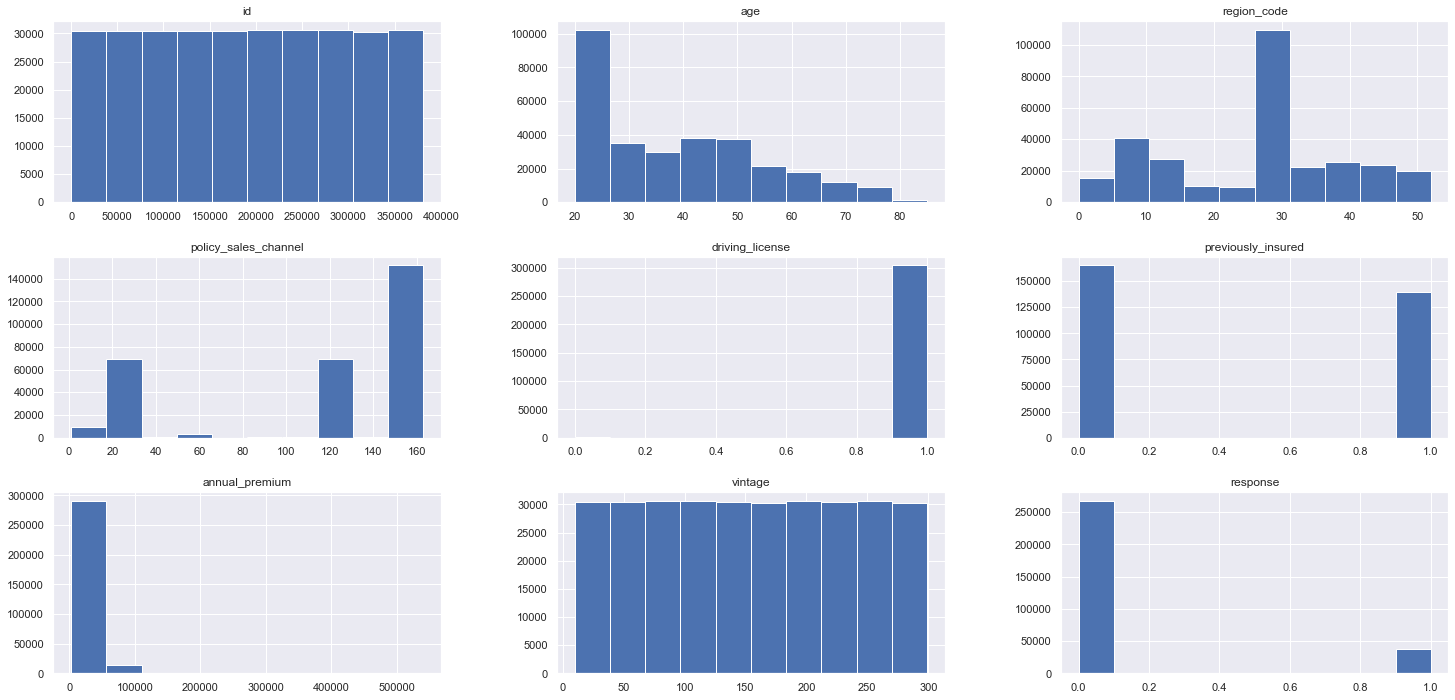

In [21]:
num_attributes.hist();

### 1.6.2 Categorical Attributes

In [22]:
cat_attributes.describe()

,gender,vehicle_age,vehicle_damage
count,304887,304887,304887
unique,2,3,2
top,Male,1-2 Year,Yes
freq,164780,160195,153959


### 1.6.3 Some Conclusions

Significant portion of customers (54,2%) don't have vehicle insurance
 
Most 95% of customer have license

All customers have less than one year of insurance and have a constant distribution 

Most customers are under 50 years old, 25% are up to 25 years old 

Most 95% of annual premmium cost until 55.292 and the range is 537535.0

Most customer are Male

Most customers vehicles age is less 2 years

Customers who have had the vehicle damaged in the past are evenly distributed to customers who have not had the vehicle damaged

Most 75% of customers don't have interest to buy a vehicle insurance

# 2.0 Feature Engineering

In [23]:
df02 = df01.copy()

In [24]:
# Age Stage
df02['age_stage'] = df02['age'].apply(lambda row: age_stage(row))

# vehicle age
vehicle_age_mapping = {'< 1 Year':0,
                       '1-2 Year':1,
                       '> 2 Years':2}

df02['vehicle_age'] = df02['vehicle_age'].map(vehicle_age_mapping)

# vehicle demage versus license
vehicle_damage_mapping = {'No':0,
                          'Yes':1}

df02['vehicle_damage'] = df02['vehicle_damage'].map(vehicle_damage_mapping)
df02['vehicle_damage_license'] = df02.apply(lambda row: -(row['vehicle_damage'] + row['driving_license'])**2 if row['driving_license'] == 0 else (row['vehicle_damage'] + row['driving_license'])**2, axis=1)


# vehicle_damage_vehicle_age
df02['vehicle_damage_vehicle_age'] = df02.apply(lambda row: -(row['vehicle_damage'] + row['vehicle_age'])**2 if row['vehicle_damage'] == 1 else (row['vehicle_damage'] + row['vehicle_age'])**2, axis=1)

# age / mean_age_by_region_code
region_code_mean_age = pd.DataFrame(df02.groupby('region_code')['age'].mean()).reset_index().rename(columns={'age':'mean_age_by_region_code'})
df02 = pd.merge(df02, region_code_mean_age, how='left', on='region_code')

df02['age_mean_age_by_region_code'] = df02['age'] / df02['mean_age_by_region_code']
del region_code_mean_age


# age / mean_age_by_policy_sales_channel
policy_sales_channel_mean_age = pd.DataFrame(df02.groupby('policy_sales_channel')['age'].mean()).reset_index().rename(columns={'age':'mean_age_by_policy_sales_channel'})
df02 = pd.merge(df02, policy_sales_channel_mean_age, how='left', on='policy_sales_channel')

df02['age_mean_age_by_policy_sales_channel'] = df02['age'] / df02['mean_age_by_policy_sales_channel']
del policy_sales_channel_mean_age


# annual_premium / mean_annual_premium_by_region_code
region_code_mean_annual_premium = pd.DataFrame(df02.groupby('region_code')['annual_premium'].mean()).reset_index().rename(columns={'annual_premium':'mean_annual_premium_by_region_code'})
df02 = pd.merge(df02, region_code_mean_annual_premium, how='left', on='region_code')

df02['annual_premium_mean_annual_premium_by_region_code'] = df02['annual_premium'] / df02['mean_annual_premium_by_region_code']
del region_code_mean_annual_premium


# annual_premium / mean_annual_premium_by_policy_sales_channel
policy_sales_channel_mean_annual_premium = pd.DataFrame(df02.groupby('policy_sales_channel')['annual_premium'].mean()).reset_index().rename(columns={'annual_premium':'mean_annual_premium_by_policy_sales_channel'})
df02 = pd.merge(df02, policy_sales_channel_mean_annual_premium, how='left', on='policy_sales_channel')

df02['annual_premium_mean_annual_premium_by_policy_sales_channel'] = df02['annual_premium'] / df02['mean_annual_premium_by_policy_sales_channel']
del policy_sales_channel_mean_annual_premium

# age / vintage
df02['age_vintage'] = (df02['age']*365) / df02['vintage']

In [25]:
df02.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response,age_stage,vehicle_damage_license,vehicle_damage_vehicle_age,mean_age_by_region_code,age_mean_age_by_region_code,mean_age_by_policy_sales_channel,age_mean_age_by_policy_sales_channel,mean_annual_premium_by_region_code,annual_premium_mean_annual_premium_by_region_code,mean_annual_premium_by_policy_sales_channel,annual_premium_mean_annual_premium_by_policy_sales_channel,age_vintage
0,274711,Male,22,40.0,152.0,1,0,1,0,25455.0,203,0,Young,4,-1,36.126083,0.608978,26.216985,0.839151,26217.691049,0.970909,30906.365442,0.823617,39.556650
1,216540,Female,26,8.0,26.0,1,0,0,1,38393.0,45,0,Young,1,0,38.562716,0.674226,50.689887,0.512923,36461.222566,1.052982,33647.867005,1.141023,210.888889
2,78984,Female,32,28.0,122.0,1,0,1,0,32118.0,35,1,Adult,4,-1,46.280311,0.691439,52.148535,0.613632,38728.647477,0.829309,37184.874104,0.863738,333.714286
3,218369,Male,32,37.0,152.0,1,0,1,0,37711.0,215,0,Adult,4,-1,32.427888,0.986805,26.216985,1.220583,28400.320346,1.327837,30906.365442,1.220169,54.325581
4,307216,Female,24,28.0,156.0,1,0,1,0,48706.0,222,0,Young,4,-1,46.280311,0.518579,39.034703,0.614838,38728.647477,1.257622,11436.615911,4.258777,39.459459


# 3.0 Data Filtering

In [26]:
df03 = df02.copy()

## 3.1 Filtering Rows

## 3.2 Filtering Columns

In [27]:
cols_drop = ['id', # original data
             'mean_age_by_region_code', 'mean_age_by_policy_sales_channel', 'mean_annual_premium_by_region_code', 'mean_annual_premium_by_policy_sales_channel'] # auxiliary features
df03 = df03.drop(cols_drop, axis=1)

# 4.0 Balanced Dataset

In [28]:
df04 = df03.copy()

## 4.1 SMOTE + TOMEKLINK

In [29]:
# Encoder Categorical Variables
ohe = OneHotEncoder()

# Numerical
col_num = df04.select_dtypes(include=['int64', 'float64']).drop('response', axis=1).columns.tolist()

# Categorical
col_cat = df04.select_dtypes(exclude=['int64', 'float64']).columns.tolist()

# Encoding
df04_dummy = pd.DataFrame(ohe.fit_transform(df04[col_cat]).toarray(), index=df04.index)

# join Numerical and Categorical
df04_1 = pd.concat([df04[col_num], df04_dummy], axis=1)

In [30]:
ratio_balanced = {
                    0: 267519,
                    1:7*37368
                }

#ratio_balanced

In [31]:
# define sampler
smt = c.SMOTETomek(sampling_strategy=ratio_balanced, random_state=32, n_jobs=-1)

# apply sampler
X_smt, y_smt = smt.fit_resample(df04_1, df04['response'])

In [32]:
# numerical data
df04_2 = X_smt[col_num]

# categorical data
df04_3 = X_smt.drop(col_num, axis=1)
df04_4 = pd.DataFrame(ohe.inverse_transform(df04_3), columns=col_cat, index=df04_3.index)

# join numerical and categorical
df04_5 = pd.concat([df04_2, df04_4], axis=1)
df04_5['response'] = y_smt

# 5.0 Exploratory Data Analysis (EDA)

In [33]:
df05_u = df04.copy()
df05 = df04_5.copy()

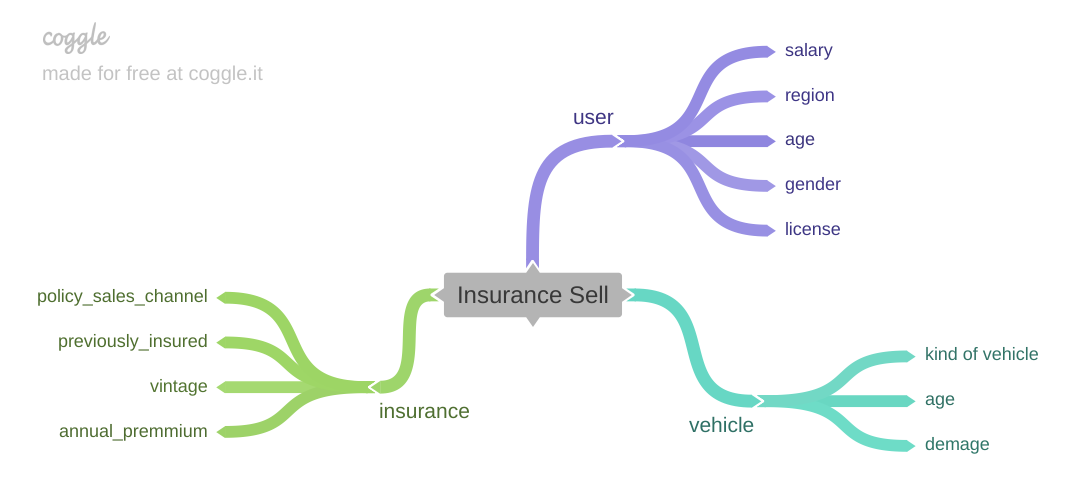

In [34]:
Image('../img/insurance_sell.png')

## 5.1 Univariate Analysis - Feature Bahaviour (Balanced Dataset)

In [35]:
profile = ProfileReport(df05, title="Insurance Cross Sell", html={'style': {'full_width':True}}, minimal=True)

profile.to_file(output_file='insurance_cross_sell.html')

## 5.2 Bivariate Analysis - Hypothesis Validation (Unbalanced dataset)

### 5.2.1 Hypothesis

> - **H01** - Customers over 30 years old purchase vehicle insurance more frequently
> - **H02** - Unlicensed customers do not purchase insurance
> - **H03** - Customers who already have vehicle insurance do not require the insurance offered
> - **H04** - Customers with vehicle that are less than 1 year old purchase insurance
> - **H05** - Longer customers who own vehicles that are more than 2 years old acquire insurance
> - **H06** - Male customers who own vehicles over 2 years of age do not acquire insurance
> - **H07** - Older customers in the portfolio acquire insurance
> - **H08** - Elderly customers do not purchase insurance
> - **H09** - Female customers already have vehicle insurance
> - **H10** - Customers with new and damaged vehicles purchase insurance
> - **H11** - Customers who have a plan that costs more than the average in the region acquire insurance
> - **H12** - Older customers in the portfolio are from the region 28
> - **H13** - Young customers came through channel 152
> - **H14** - Among the damaged cars, the largest portion belongs to young customers 

### 5.2.2 Final List of Hypothesis

> - **H01** - Customers over 30 years old purchase vehicle insurance
> - **H02** - Customers who already have vehicle insurance do not require the insurance offered
> - **H03** - Customers with vehicle that are less than 1 year old purchase insurance
> - **H04** - Longer customers who own vehicles that are more than 2 years old acquire insurance
> - **H05** - Male customers who own vehicles over 2 years of age do not acquire insurance

#### **H01** - Customers over 30 years old purchase vehicle insurance more frequently
---
> **Conclusion: TRUE**
>> - Customers over 30 years old purchase vehicle insurance more frequently

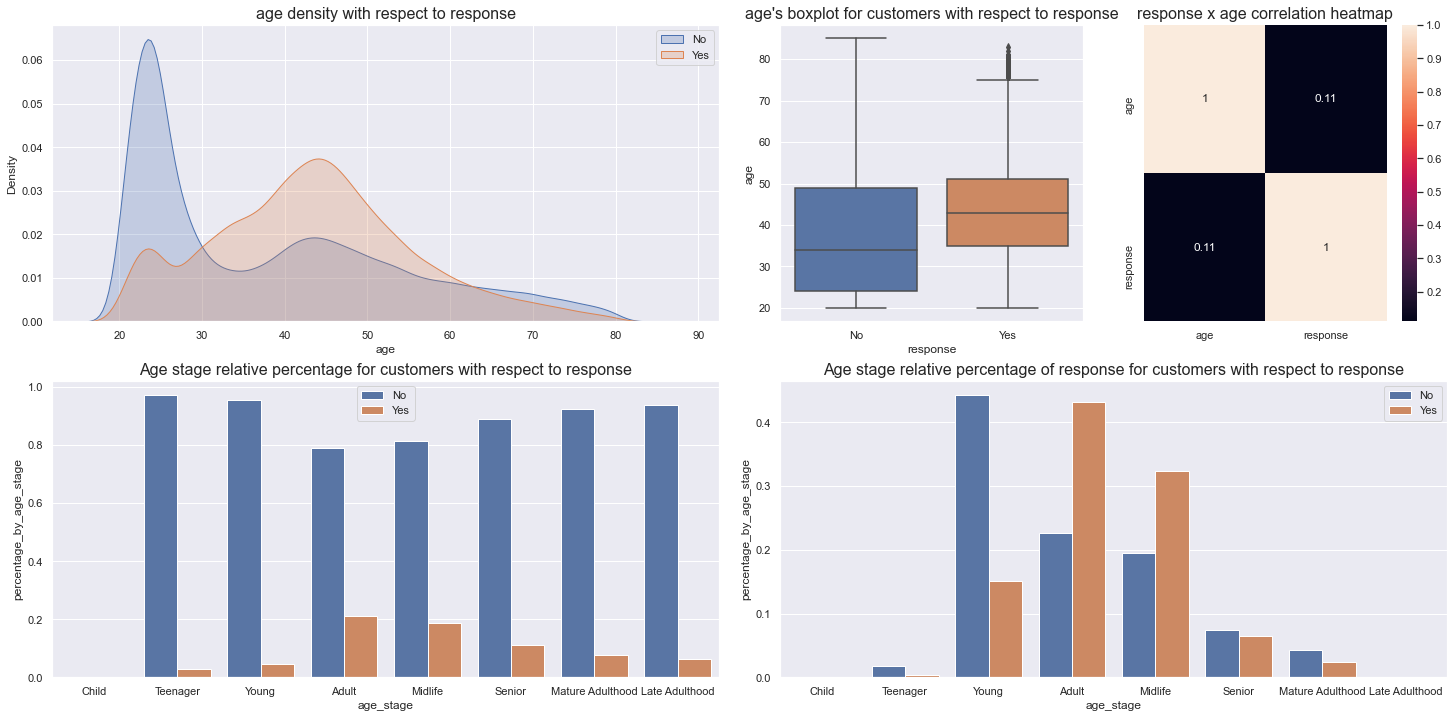

In [36]:
aux01 = df05_u[['age', 'age_stage', 'response']]


# Grid for ploting
grid = GridSpec(2, 4)

# response x age correlation heatmap
plt.subplot(grid[0,3:4])
sns.heatmap(aux01.corr(method='pearson'), annot=True).set_title("response x age correlation heatmap", fontsize=16);

# Change response to Yes/No
aux01['response'] = aux01['response'].apply(lambda row: 'Yes' if row == 1 else 'No')

# age density with respect to response
plt.subplot(grid[0,:2])
sns.kdeplot(aux01[aux01['response'] == 'No']['age'], label='No', shade=True);
sns.kdeplot(aux01[aux01['response'] == 'Yes']['age'], label='Yes', shade=True);
plt.title("age density with respect to response", fontsize=16);
plt.legend();

# age's boxplot for customers with respect to response
plt.subplot(grid[0,2:3])
sns.boxplot(x="response", y="age", data=aux01).set_title("age's boxplot for customers with respect to response", fontsize=16);

# Age stage relative percentage for customers with respect to response
aux02 = pd.DataFrame()
age_stage_unique = aux01['age_stage'].unique().tolist()
for stage in age_stage_unique:
    aux02_0 = aux01[aux01['age_stage'] == stage][['age_stage', 'response']].value_counts(normalize=True).reset_index().rename(columns={0: 'percentage_by_age_stage'})
    aux02 = pd.concat([aux02, aux02_0])

## sort the x axis
age_stage_order = ['Child', 'Teenager', 'Young', 'Adult','Midlife','Senior','Mature Adulthood','Late Adulthood']
aux02['age_stage'] = pd.Categorical(aux02['age_stage'], categories=age_stage_order, ordered =True)
aux02.sort_values('age_stage')

## plot
plt.subplot(grid[1,:2])
sns.barplot(x='age_stage', y='percentage_by_age_stage', hue='response', data=aux02);
plt.legend();
plt.title("Age stage relative percentage for customers with respect to response", fontsize=16);

# Age stage relative percentage of response for customers with respect to response
aux02_0 = aux01[aux01['response'] == 'No'][['age_stage', 'response']].value_counts(normalize=True).reset_index().rename(columns={0: 'percentage_by_age_stage'})
aux02_1 = aux01[aux01['response'] == 'Yes'][['age_stage', 'response']].value_counts(normalize=True).reset_index().rename(columns={0: 'percentage_by_age_stage'})

aux02 = pd.concat([aux02_0, aux02_1], axis=0)

## sort the x axis
aux02['age_stage'] = pd.Categorical(aux02['age_stage'], categories=age_stage_order, ordered =True)
aux02.sort_values('age_stage')

## plot
plt.subplot(grid[1,2:4])
sns.barplot(x='age_stage', y='percentage_by_age_stage', hue='response', data=aux02);
plt.legend();
plt.title("Age stage relative percentage of response for customers with respect to response", fontsize=16);

#### **H02** - Customers who already have vehicle insurance do not require the insurance offered
---
> **Conclusion: TRUE**
>> - Customers who already have vehicle insurance do not require the insurance offered

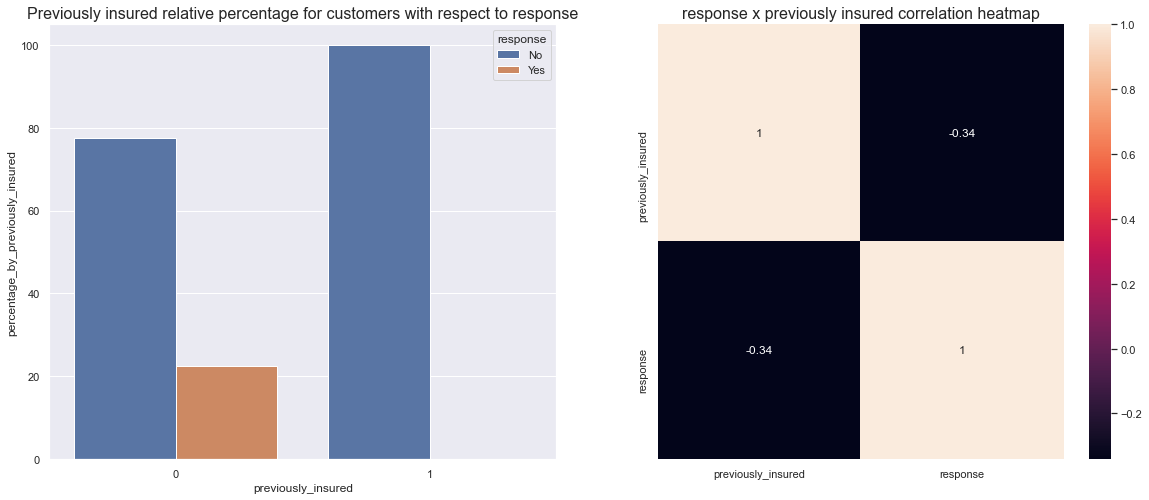

In [37]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
aux02 = df05_u[['previously_insured', 'response']]
# Previously insured relative percentage for customers with respect to response
aux02_0 = aux02[aux02['previously_insured'] == 1][['previously_insured', 'response']].value_counts(normalize=True).reset_index().rename(columns={0: 'percentage_by_previously_insured'})
aux02_1 = aux02[aux02['previously_insured'] == 0][['previously_insured', 'response']].value_counts(normalize=True).reset_index().rename(columns={0: 'percentage_by_previously_insured'})
aux03 = pd.concat([aux02_0, aux02_1], axis=0)

## Change response to Yes/No
aux03['response'] = aux03['response'].apply(lambda row: 'Yes' if row == 1 else 'No')
## transform to 100%
aux03['percentage_by_previously_insured'] = aux03['percentage_by_previously_insured'] * 100

## plot
sns.barplot(x='previously_insured', y='percentage_by_previously_insured', hue='response', data=aux03);
plt.title("Previously insured relative percentage for customers with respect to response", fontsize=16)

# response x previously insured correlation heatmap
plt.subplot(1,2,2)
sns.heatmap(aux02.corr(method='pearson'), annot=True).set_title("response x previously insured correlation heatmap", fontsize=16);

#### **H03** - Customers with vehicle that are less than 1 year old purchase insurance
---
> **Conclusion: FALSE**
>> - Customers with vehicle that are less than 1 year old do not purchase insurance

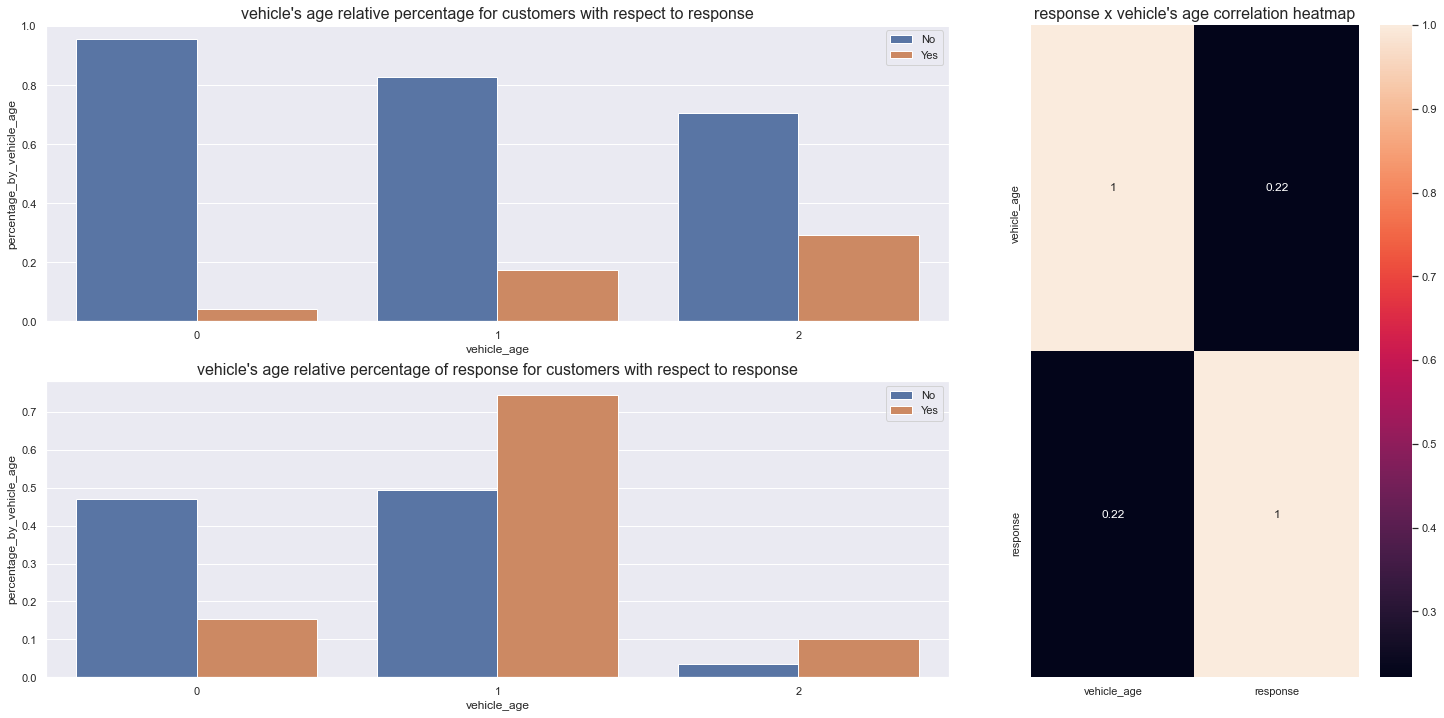

In [38]:
aux03 = df05_u[['vehicle_age', 'response']]

# Grid for ploting
plt.figure(figsize=(25, 12))
grid = GridSpec(2, 3)

# response x vehicle's age correlation heatmap
plt.subplot(grid[:,2])
sns.heatmap(aux03.corr(method='pearson'), annot=True).set_title("response x vehicle's age correlation heatmap", fontsize=16);

# Change response to Yes/No
aux03['response'] = aux03['response'].apply(lambda row: 'Yes' if row == 1 else 'No')

# vehicle's age relative percentage for customers with respect to response
aux04 = pd.DataFrame()
vehicle_age_unique = aux03['vehicle_age'].unique().tolist()
for age in vehicle_age_unique:
    aux04_0 = aux03[aux03['vehicle_age'] == age][['vehicle_age', 'response']].value_counts(normalize=True).reset_index().rename(columns={0: 'percentage_by_vehicle_age'})
    aux04 = pd.concat([aux04, aux04_0])

## plot
plt.subplot(grid[0,:2])
sns.barplot(x='vehicle_age', y='percentage_by_vehicle_age', hue='response', data=aux04);
plt.legend();
plt.title("vehicle's age relative percentage for customers with respect to response", fontsize=16);



# Age stage relative percentage of response for customers with respect to response
aux03_0 = aux03[aux03['response'] == 'No'][['vehicle_age', 'response']].value_counts(normalize=True).reset_index().rename(columns={0: 'percentage_by_vehicle_age'})
aux03_1 = aux03[aux03['response'] == 'Yes'][['vehicle_age', 'response']].value_counts(normalize=True).reset_index().rename(columns={0: 'percentage_by_vehicle_age'})
aux03 = pd.concat([aux03_0, aux03_1], axis=0)

## plot
plt.subplot(grid[1,:2])
sns.barplot(x='vehicle_age', y='percentage_by_vehicle_age', hue='response', data=aux03);
plt.legend();
plt.title("vehicle's age relative percentage of response for customers with respect to response", fontsize=16);

#### **H04** -  Longer customers who own vehicles that are more than 2 years old acquire insurance
---
> **Conclusion: FALSE**
>> - Longer customers who own vehicles that are more than 2 years old acquire insurance in the same frequency of the other customers

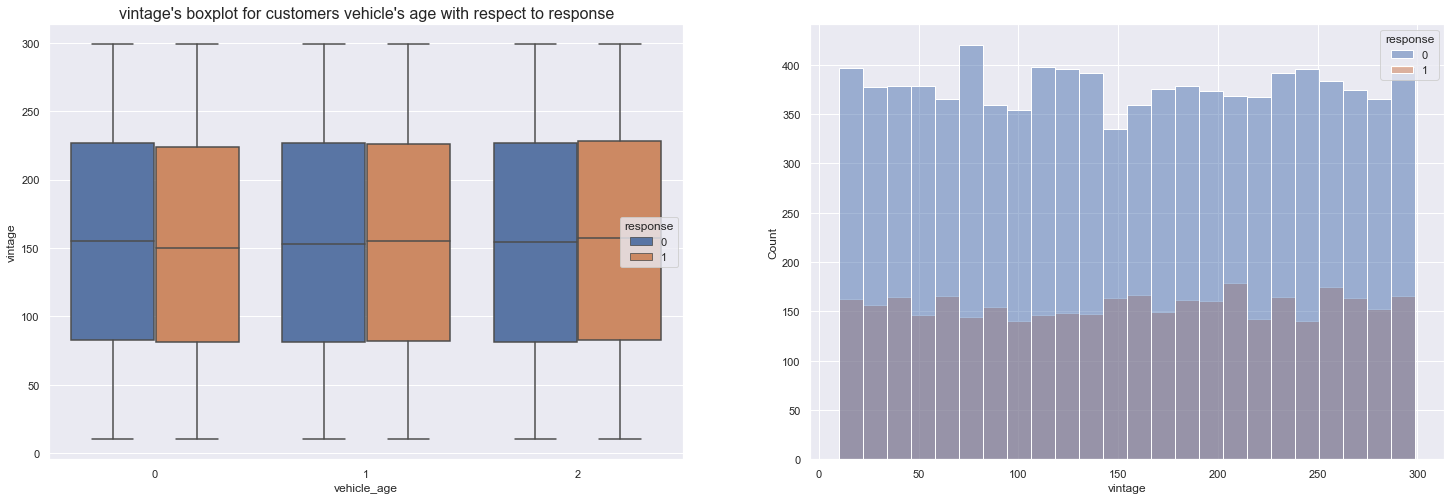

In [39]:
aux04 = df05_u[['vintage','vehicle_age', 'response']]

plt.figure(figsize=(25,8))
# age's boxplot for customers with respect to response
plt.subplot(1,2,1)
sns.boxplot(x="vehicle_age", y="vintage", hue="response", data=aux04).set_title("vintage's boxplot for customers vehicle's age with respect to response", fontsize=16);

plt.subplot(1,2,2)
sns.histplot(x='vintage', data=aux04[aux04['vehicle_age'] == 2], hue='response');

#### **H05** - Male customers who own vehicles over 2 years of age do not acquire insurance
---
> **Conclusion: **
>> - 

## 5.3 Multivariable analysis (Balanced Dataset)

In [40]:
num_attributes = df05.select_dtypes(include=['int64', 'float64'])
cat_attributes = df05.select_dtypes(exclude=['int64', 'float64'])

### 5.3.1 Numerical

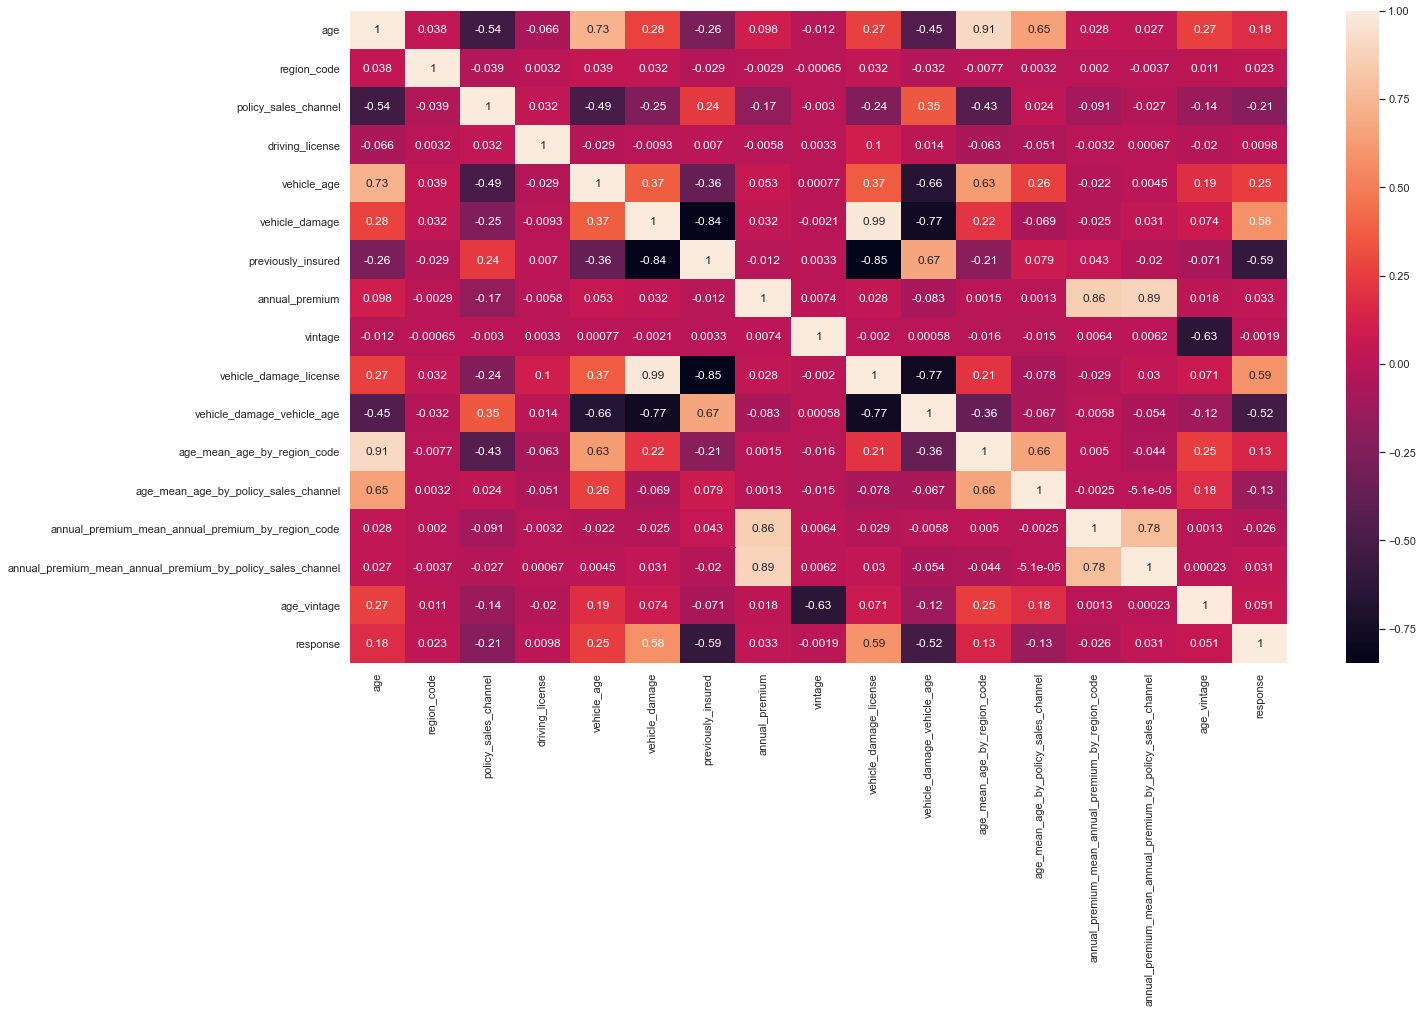

In [41]:
correlation = num_attributes.corr(method='pearson')
plt.figure(figsize=(21,12))
sns.heatmap(correlation, annot=True);

### 5.3.2 Categorical

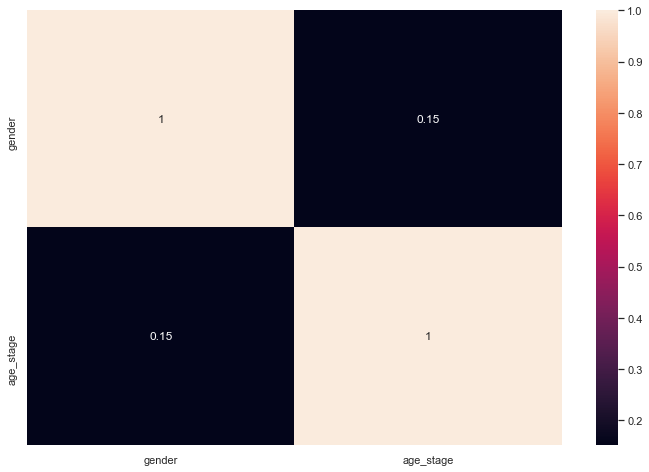

In [42]:
# list of attributes for Cramer's V correlation
cat_attributes_list = cat_attributes.columns.tolist()

corr_dict = {}
for i in range(len(cat_attributes_list)):
    corr_list = []
    for j in range(len(cat_attributes_list)):
        ref = cat_attributes_list[i]
        feat = cat_attributes_list[j]
        
        # correlation
        corr = cramer_v(cat_attributes[ref], cat_attributes[feat])
        
        # append list
        corr_list.append(corr)
        
    # append correlation list for each ref attributes  
    corr_dict[ref] = corr_list
    
d = pd.DataFrame(corr_dict)
d = d.set_index(d.columns)
plt.figure(figsize=(12,8))
sns.heatmap(d, annot=True);

# 6.0 Data Filtering (Attributes with High Correlation)

In [43]:
cols_drop = ['age', 'vehicle_damage', 'annual_premium']
df06 = df05.drop(cols_drop, axis=1)

#df06 = df05.copy() ### will be changed

# 7.0 Data Preparation

In [44]:
# Numerical
num_attributes = df06.select_dtypes(include=['int64', 'float64'])
# Categorical
cat_attributes = df06.select_dtypes(exclude=['int64', 'float64'])

## 7.1 Rescaling

## 7.2 Encoding

In [45]:
# Dummy variable
df07_dummy = pd.get_dummies(cat_attributes)

# Join id and country_destination
df07 = pd.concat([num_attributes, df07_dummy], axis=1)

## 7.3 Transformation

# 8.0 Feature Selection

In [46]:
df08 = df07.copy()

## 8.1 Boruta as Feature Selector

In [47]:
X = df08.drop(columns=['response'], axis=1)
y = df08['response'].copy()


# Training and Validation dataset for Boruta
X_train_n = X.to_numpy()
y_train_n = y.values.ravel()

# define RandomForestClassifier
rf = RandomForestClassifier(n_jobs=-1)

# define Boruta
boruta = BorutaPy(rf, verbose=1, n_estimators='auto', random_state=42)
boruta.fit(X_train_n, y_train_n)

Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100
Iteration: 9 / 100
Iteration: 10 / 100
Iteration: 11 / 100
Iteration: 12 / 100
Iteration: 13 / 100
Iteration: 14 / 100
Iteration: 15 / 100
Iteration: 16 / 100
Iteration: 17 / 100
Iteration: 18 / 100
Iteration: 19 / 100
Iteration: 20 / 100
Iteration: 21 / 100
Iteration: 22 / 100


BorutaPy finished running.

Iteration: 	23 / 100
Confirmed: 	11
Tentative: 	0
Rejected: 	11


BorutaPy(estimator=RandomForestClassifier(n_estimators=48, n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x2E908990B40),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x2E908990B40, verbose=1)

In [48]:
cols_selected = boruta.support_.tolist()

# Best Features
X_train_fs = X
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.tolist()

cols_not_select_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))
cols_selected_boruta

['region_code',
 'policy_sales_channel',
 'previously_insured',
 'vintage',
 'vehicle_damage_license',
 'vehicle_damage_vehicle_age',
 'age_mean_age_by_region_code',
 'age_mean_age_by_policy_sales_channel',
 'annual_premium_mean_annual_premium_by_region_code',
 'annual_premium_mean_annual_premium_by_policy_sales_channel',
 'age_vintage']

## 8.? Split into Train and Validation

In [49]:
# cols_selected = ['age',
#                  'region_code',
#                  'policy_sales_channel',
#                  'vehicle_damage',
#                  'previously_insured',
#                  'annual_premium',
#                  'vintage',
#                  'vehicle_damage_license',
#                  'vehicle_damage_vehicle_age',
#                  'age_mean_age_by_region_code',
#                  'age_mean_age_by_policy_sales_channel',
#                  'annual_premium_mean_annual_premium_by_region_code',
#                  'annual_premium_mean_annual_premium_by_policy_sales_channel',
#                  'age_vintage']

cols_selected = ['region_code',
                 'policy_sales_channel',
                 'previously_insured',
                 'vintage',
                 'vehicle_damage_license',
                 'vehicle_damage_vehicle_age',
                 'age_mean_age_by_region_code',
                 'age_mean_age_by_policy_sales_channel',
                 'annual_premium_mean_annual_premium_by_region_code',
                 'annual_premium_mean_annual_premium_by_policy_sales_channel',
                 'age_vintage']


X = df08[cols_selected]
y = df08['response'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32, stratify=y)

# 9.0 Machine Learning Model

## 9.1 Baseline model

### 9.1.1 Random Choices

In [50]:
response_list = y_train.drop_duplicates().sort_values().tolist()
response_weights = y_train.value_counts(normalize=True).sort_index().tolist()
k_num = y_test.shape[0]

# Random Model

yhat_random = random.choices(population=response_list,
                             weights=response_weights,
                             k=k_num)

### 9.1.2 Random Choices Performance

Accuracy: 0.49855773884425514
Balanced Accuracy: 0.49853461533849563
Kappa Score: -0.0029305161630637233
              precision    recall  f1-score   support

           0       0.50      0.50      0.50     52249
           1       0.49      0.50      0.49     51061

    accuracy                           0.50    103310
   macro avg       0.50      0.50      0.50    103310
weighted avg       0.50      0.50      0.50    103310



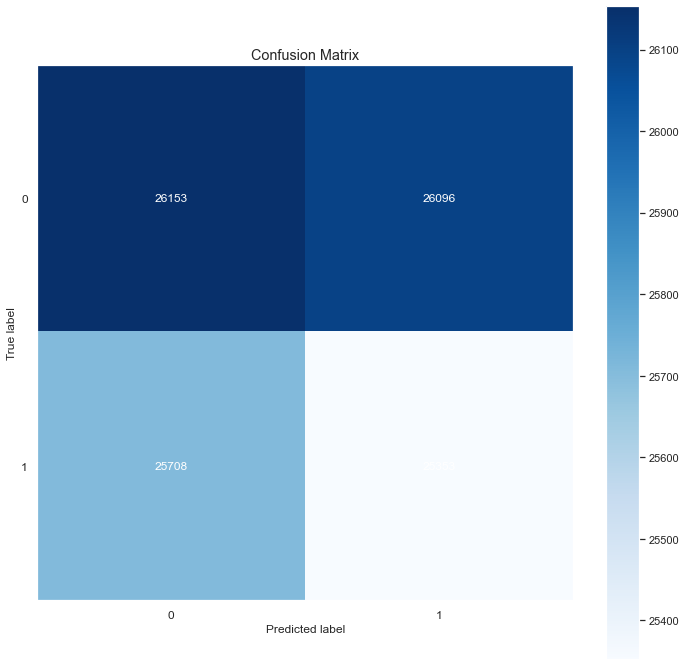

In [51]:
# Accuracy
acc_random = accuracy_score(y_test, yhat_random)
print('Accuracy: {}'.format(acc_random))

# Balanced Accuracy
balanced_acc_random = balanced_accuracy_score(y_test, yhat_random)
print('Balanced Accuracy: {}'.format(balanced_acc_random))

# Kappa Score
kappa_random = cohen_kappa_score(y_test, yhat_random)
print('Kappa Score: {}'.format(kappa_random))

# Classification Report
print(classification_report(y_test, yhat_random))

# Confusion matrix
plot_confusion_matrix(y_test, yhat_random, normalize=False, figsize=(12, 12));

## 9.2 Machine Learning Model

### 9.2.1 Random Forest

In [52]:
# Model
rf = RandomForestClassifier(n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

yhat_rf = rf.predict(X_test)

#### 9.2.1.1 Performance

Accuracy: 0.9121188655502855
Balanced Accuracy: 0.912118264089863
Kappa Score: 0.8242183606187878
              precision    recall  f1-score   support

           0       0.91      0.91      0.91     52249
           1       0.91      0.91      0.91     51061

    accuracy                           0.91    103310
   macro avg       0.91      0.91      0.91    103310
weighted avg       0.91      0.91      0.91    103310



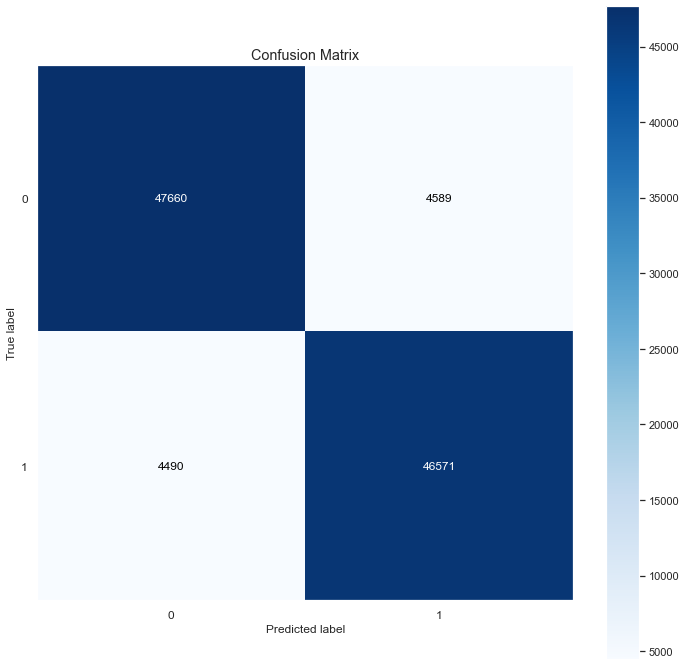

In [53]:
# Accuracy
acc_rf = accuracy_score(y_test, yhat_rf)
print('Accuracy: {}'.format(acc_rf))

# Balanced Accuracy
balanced_acc_rf = balanced_accuracy_score(y_test, yhat_rf)
print('Balanced Accuracy: {}'.format(balanced_acc_rf))

# Kappa Score
kappa_rf = cohen_kappa_score(y_test, yhat_rf)
print('Kappa Score: {}'.format(kappa_rf))

# Classification Report
print(classification_report(y_test, yhat_rf))

# Confusion matrix
plot_confusion_matrix(y_test, yhat_rf, normalize=False, figsize=(12, 12));

#### 9.2.1.2 Performance - Cross Validation

In [54]:
model = RandomForestClassifier(n_jobs=-1, random_state=42)
result_rf = cross_validation(X_train, y_train, 'Random Forest', model, num_folds=5, verbose=True)
result_rf

Fold Number: 1/5
Fold Number: 2/5
Fold Number: 3/5
Fold Number: 4/5
Fold Number: 5/5


,Model Name,Precision CV,Recall CV,F1 Score CV,Kappa CV,Balanced Accuracy,Average Precision Score CV,ROC AUC CV
0,Random Forest,0.9051 +/- 0.0007,0.9103 +/- 0.0017,0.9077 +/- 0.0009,0.817 +/- 0.0016,0.9085 +/- 0.0008,0.9777 +/- 0.0003,0.9761 +/- 0.0003


### 9.2.2 XGBoost Classifier

In [55]:
xgb = XGBClassifier(n_jobs=-1, random_state=42)
xgb.fit(X_train, y_train)

# Prediction
yhat_xgb = xgb.predict(X_test)

#### 9.2.2.1 Performance

Accuracy: 0.9082567031265124
Balanced Accuracy: 0.9080277104729223
Kappa Score: 0.8164095129788094
              precision    recall  f1-score   support

           0       0.89      0.93      0.91     52249
           1       0.92      0.89      0.91     51061

    accuracy                           0.91    103310
   macro avg       0.91      0.91      0.91    103310
weighted avg       0.91      0.91      0.91    103310



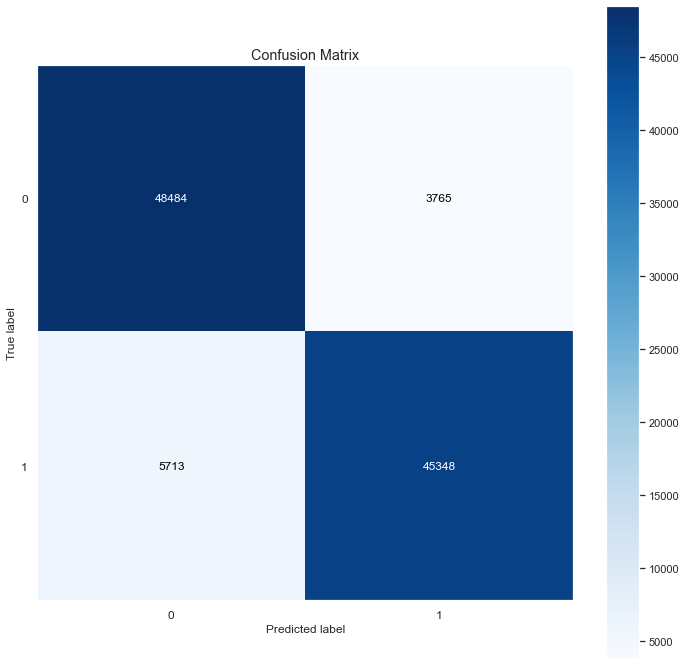

In [56]:
# Accuracy
acc_xgb = accuracy_score(y_test, yhat_xgb)
print('Accuracy: {}'.format(acc_xgb))

# Balanced Accuracy
balanced_acc_xgb = balanced_accuracy_score(y_test, yhat_xgb)
print('Balanced Accuracy: {}'.format(balanced_acc_xgb))

# Kappa Score
kappa_xgb = cohen_kappa_score(y_test, yhat_xgb)
print('Kappa Score: {}'.format(kappa_xgb))

# Classification Report
print(classification_report(y_test, yhat_xgb))

# Confusion matrix
plot_confusion_matrix(y_test, yhat_xgb, normalize=False, figsize=(12, 12));

#### 9.2.2.2 Performance - Cross Validation

In [57]:
model = XGBClassifier(n_jobs=-1, random_state=42)
result_xgb = cross_validation(X_train, y_train, 'XGBoost Classifier', model, num_folds=5, verbose=True)
result_xgb

Fold Number: 1/5
Fold Number: 2/5
Fold Number: 3/5
Fold Number: 4/5
Fold Number: 5/5


,Model Name,Precision CV,Recall CV,F1 Score CV,Kappa CV,Balanced Accuracy,Average Precision Score CV,ROC AUC CV
0,XGBoost Classifier,0.9245 +/- 0.0033,0.8877 +/- 0.0026,0.9058 +/- 0.0009,0.8173 +/- 0.0019,0.9085 +/- 0.0009,0.9787 +/- 0.0002,0.976 +/- 0.0003


### 9.2.3 LightGBM Classifier

In [58]:
lgbm = LGBMClassifier(n_jobs=-1, random_state=42)
lgbm.fit(X_train, y_train)

# Prediction
yhat_lgbm = lgbm.predict(X_test)

#### 9.2.3.1 Performance

Accuracy: 0.8903591133481754
Balanced Accuracy: 0.8904513728115409
Kappa Score: 0.7807360431730735
              precision    recall  f1-score   support

           0       0.90      0.88      0.89     52249
           1       0.88      0.90      0.89     51061

    accuracy                           0.89    103310
   macro avg       0.89      0.89      0.89    103310
weighted avg       0.89      0.89      0.89    103310



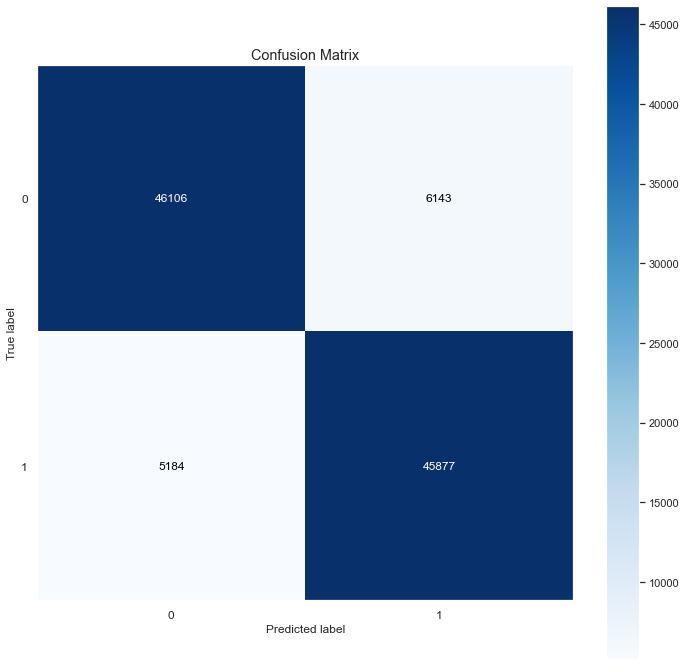

In [59]:
# Accuracy
acc_lgbm = accuracy_score(y_test, yhat_lgbm)
print('Accuracy: {}'.format(acc_lgbm))

# Balanced Accuracy
balanced_acc_lgbm = balanced_accuracy_score(y_test, yhat_lgbm)
print('Balanced Accuracy: {}'.format(balanced_acc_lgbm))

# Kappa Score
kappa_lgbm = cohen_kappa_score(y_test, yhat_lgbm)
print('Kappa Score: {}'.format(kappa_lgbm))

# Classification Report
print(classification_report(y_test, yhat_lgbm))

# Confusion matrix
plot_confusion_matrix(y_test, yhat_lgbm, normalize=False, figsize=(12, 12));

#### 9.2.3.2 Performance - Cross Validation

In [60]:
model = LGBMClassifier(n_jobs=-1, random_state=42)
result_lgbm = cross_validation(X_train, y_train, 'Lightgbm Classifier', model, num_folds=5, verbose=True)
result_lgbm

Fold Number: 1/5
Fold Number: 2/5
Fold Number: 3/5
Fold Number: 4/5
Fold Number: 5/5


,Model Name,Precision CV,Recall CV,F1 Score CV,Kappa CV,Balanced Accuracy,Average Precision Score CV,ROC AUC CV
0,Lightgbm Classifier,0.8835 +/- 0.003,0.8976 +/- 0.0021,0.8905 +/- 0.0009,0.7818 +/- 0.0022,0.891 +/- 0.0011,0.9733 +/- 0.0004,0.9708 +/- 0.0005


### 9.2.4 Catboost Classifier

In [61]:
catb = CatBoostClassifier(random_state=42)
catb.fit(X_train, y_train)

# Prediction
yhat_catb = catb.predict(X_test)

Learning rate set to 0.134912
0:	learn: 0.5587474	total: 197ms	remaining: 3m 16s
1:	learn: 0.4937477	total: 243ms	remaining: 2m 1s
2:	learn: 0.4483504	total: 298ms	remaining: 1m 39s
3:	learn: 0.4222001	total: 357ms	remaining: 1m 28s
4:	learn: 0.4080337	total: 413ms	remaining: 1m 22s
5:	learn: 0.3975865	total: 467ms	remaining: 1m 17s
6:	learn: 0.3887726	total: 510ms	remaining: 1m 12s
7:	learn: 0.3799853	total: 556ms	remaining: 1m 8s
8:	learn: 0.3741140	total: 600ms	remaining: 1m 6s
9:	learn: 0.3698633	total: 648ms	remaining: 1m 4s
10:	learn: 0.3621337	total: 692ms	remaining: 1m 2s
11:	learn: 0.3590641	total: 733ms	remaining: 1m
12:	learn: 0.3569175	total: 778ms	remaining: 59.1s
13:	learn: 0.3517294	total: 828ms	remaining: 58.3s
14:	learn: 0.3485244	total: 875ms	remaining: 57.5s
15:	learn: 0.3461197	total: 920ms	remaining: 56.6s
16:	learn: 0.3436399	total: 966ms	remaining: 55.9s
17:	learn: 0.3414337	total: 1.01s	remaining: 55.2s
18:	learn: 0.3388880	total: 1.06s	remaining: 54.7s
19:	lear

164:	learn: 0.2308968	total: 8.43s	remaining: 42.7s
165:	learn: 0.2305806	total: 8.48s	remaining: 42.6s
166:	learn: 0.2300580	total: 8.53s	remaining: 42.6s
167:	learn: 0.2298001	total: 8.61s	remaining: 42.6s
168:	learn: 0.2296655	total: 8.68s	remaining: 42.7s
169:	learn: 0.2291340	total: 8.73s	remaining: 42.6s
170:	learn: 0.2287961	total: 8.78s	remaining: 42.6s
171:	learn: 0.2285769	total: 8.83s	remaining: 42.5s
172:	learn: 0.2284159	total: 8.88s	remaining: 42.4s
173:	learn: 0.2282937	total: 8.93s	remaining: 42.4s
174:	learn: 0.2280562	total: 8.97s	remaining: 42.3s
175:	learn: 0.2277672	total: 9.02s	remaining: 42.2s
176:	learn: 0.2276629	total: 9.06s	remaining: 42.2s
177:	learn: 0.2273787	total: 9.11s	remaining: 42.1s
178:	learn: 0.2272661	total: 9.15s	remaining: 42s
179:	learn: 0.2270914	total: 9.2s	remaining: 41.9s
180:	learn: 0.2268273	total: 9.24s	remaining: 41.8s
181:	learn: 0.2263870	total: 9.3s	remaining: 41.8s
182:	learn: 0.2257832	total: 9.35s	remaining: 41.7s
183:	learn: 0.22

325:	learn: 0.2006744	total: 16.8s	remaining: 34.7s
326:	learn: 0.2006227	total: 16.9s	remaining: 34.7s
327:	learn: 0.2004720	total: 16.9s	remaining: 34.6s
328:	learn: 0.2004035	total: 17s	remaining: 34.6s
329:	learn: 0.2003482	total: 17s	remaining: 34.5s
330:	learn: 0.2003190	total: 17.1s	remaining: 34.5s
331:	learn: 0.2002482	total: 17.1s	remaining: 34.4s
332:	learn: 0.2001974	total: 17.2s	remaining: 34.4s
333:	learn: 0.2001517	total: 17.2s	remaining: 34.4s
334:	learn: 0.2001117	total: 17.3s	remaining: 34.3s
335:	learn: 0.2000468	total: 17.3s	remaining: 34.3s
336:	learn: 0.1999414	total: 17.4s	remaining: 34.2s
337:	learn: 0.1998562	total: 17.4s	remaining: 34.1s
338:	learn: 0.1998066	total: 17.5s	remaining: 34.1s
339:	learn: 0.1996990	total: 17.5s	remaining: 34s
340:	learn: 0.1992703	total: 17.6s	remaining: 34s
341:	learn: 0.1989769	total: 17.6s	remaining: 33.9s
342:	learn: 0.1989343	total: 17.7s	remaining: 33.9s
343:	learn: 0.1988222	total: 17.7s	remaining: 33.8s
344:	learn: 0.198787

487:	learn: 0.1883668	total: 25s	remaining: 26.2s
488:	learn: 0.1883312	total: 25.1s	remaining: 26.2s
489:	learn: 0.1882227	total: 25.1s	remaining: 26.1s
490:	learn: 0.1881892	total: 25.2s	remaining: 26.1s
491:	learn: 0.1881638	total: 25.2s	remaining: 26.1s
492:	learn: 0.1879742	total: 25.3s	remaining: 26s
493:	learn: 0.1876979	total: 25.3s	remaining: 26s
494:	learn: 0.1876459	total: 25.4s	remaining: 25.9s
495:	learn: 0.1876058	total: 25.5s	remaining: 25.9s
496:	learn: 0.1875698	total: 25.5s	remaining: 25.8s
497:	learn: 0.1874980	total: 25.6s	remaining: 25.8s
498:	learn: 0.1874584	total: 25.6s	remaining: 25.7s
499:	learn: 0.1873508	total: 25.7s	remaining: 25.7s
500:	learn: 0.1873196	total: 25.7s	remaining: 25.6s
501:	learn: 0.1872549	total: 25.8s	remaining: 25.6s
502:	learn: 0.1872171	total: 25.8s	remaining: 25.5s
503:	learn: 0.1871883	total: 25.9s	remaining: 25.5s
504:	learn: 0.1871631	total: 25.9s	remaining: 25.4s
505:	learn: 0.1871250	total: 26s	remaining: 25.4s
506:	learn: 0.187098

646:	learn: 0.1807650	total: 33s	remaining: 18s
647:	learn: 0.1807417	total: 33.1s	remaining: 18s
648:	learn: 0.1807219	total: 33.1s	remaining: 17.9s
649:	learn: 0.1806509	total: 33.2s	remaining: 17.9s
650:	learn: 0.1806302	total: 33.2s	remaining: 17.8s
651:	learn: 0.1804854	total: 33.3s	remaining: 17.8s
652:	learn: 0.1804673	total: 33.3s	remaining: 17.7s
653:	learn: 0.1804360	total: 33.4s	remaining: 17.7s
654:	learn: 0.1803933	total: 33.4s	remaining: 17.6s
655:	learn: 0.1803624	total: 33.5s	remaining: 17.6s
656:	learn: 0.1803338	total: 33.5s	remaining: 17.5s
657:	learn: 0.1802581	total: 33.6s	remaining: 17.4s
658:	learn: 0.1802271	total: 33.6s	remaining: 17.4s
659:	learn: 0.1801873	total: 33.7s	remaining: 17.3s
660:	learn: 0.1801669	total: 33.7s	remaining: 17.3s
661:	learn: 0.1801434	total: 33.8s	remaining: 17.2s
662:	learn: 0.1801251	total: 33.8s	remaining: 17.2s
663:	learn: 0.1800918	total: 33.9s	remaining: 17.1s
664:	learn: 0.1800716	total: 33.9s	remaining: 17.1s
665:	learn: 0.1800

805:	learn: 0.1751075	total: 41.1s	remaining: 9.89s
806:	learn: 0.1750750	total: 41.2s	remaining: 9.84s
807:	learn: 0.1750480	total: 41.2s	remaining: 9.79s
808:	learn: 0.1750259	total: 41.3s	remaining: 9.74s
809:	learn: 0.1750020	total: 41.3s	remaining: 9.69s
810:	learn: 0.1749809	total: 41.3s	remaining: 9.64s
811:	learn: 0.1749453	total: 41.4s	remaining: 9.58s
812:	learn: 0.1749236	total: 41.4s	remaining: 9.53s
813:	learn: 0.1749015	total: 41.5s	remaining: 9.48s
814:	learn: 0.1748910	total: 41.5s	remaining: 9.43s
815:	learn: 0.1748570	total: 41.6s	remaining: 9.38s
816:	learn: 0.1748255	total: 41.7s	remaining: 9.33s
817:	learn: 0.1748049	total: 41.7s	remaining: 9.28s
818:	learn: 0.1747705	total: 41.7s	remaining: 9.23s
819:	learn: 0.1747557	total: 41.8s	remaining: 9.17s
820:	learn: 0.1747365	total: 41.8s	remaining: 9.12s
821:	learn: 0.1747101	total: 41.9s	remaining: 9.07s
822:	learn: 0.1746926	total: 41.9s	remaining: 9.02s
823:	learn: 0.1746765	total: 42s	remaining: 8.96s
824:	learn: 0.

967:	learn: 0.1710866	total: 49.7s	remaining: 1.64s
968:	learn: 0.1710629	total: 49.7s	remaining: 1.59s
969:	learn: 0.1710485	total: 49.8s	remaining: 1.54s
970:	learn: 0.1710246	total: 49.8s	remaining: 1.49s
971:	learn: 0.1710037	total: 49.8s	remaining: 1.44s
972:	learn: 0.1709833	total: 49.9s	remaining: 1.38s
973:	learn: 0.1709613	total: 49.9s	remaining: 1.33s
974:	learn: 0.1709224	total: 50s	remaining: 1.28s
975:	learn: 0.1708984	total: 50s	remaining: 1.23s
976:	learn: 0.1708782	total: 50.1s	remaining: 1.18s
977:	learn: 0.1708241	total: 50.1s	remaining: 1.13s
978:	learn: 0.1708122	total: 50.2s	remaining: 1.08s
979:	learn: 0.1707936	total: 50.2s	remaining: 1.02s
980:	learn: 0.1707787	total: 50.3s	remaining: 974ms
981:	learn: 0.1707595	total: 50.3s	remaining: 922ms
982:	learn: 0.1707458	total: 50.4s	remaining: 871ms
983:	learn: 0.1707321	total: 50.4s	remaining: 820ms
984:	learn: 0.1707157	total: 50.5s	remaining: 769ms
985:	learn: 0.1706851	total: 50.5s	remaining: 717ms
986:	learn: 0.17

#### 9.2.4.1 Performance

Accuracy: 0.9171619397928564
Balanced Accuracy: 0.9166233080267279
Kappa Score: 0.8341269138649908
              precision    recall  f1-score   support

           0       0.88      0.96      0.92     52249
           1       0.96      0.87      0.91     51061

    accuracy                           0.92    103310
   macro avg       0.92      0.92      0.92    103310
weighted avg       0.92      0.92      0.92    103310



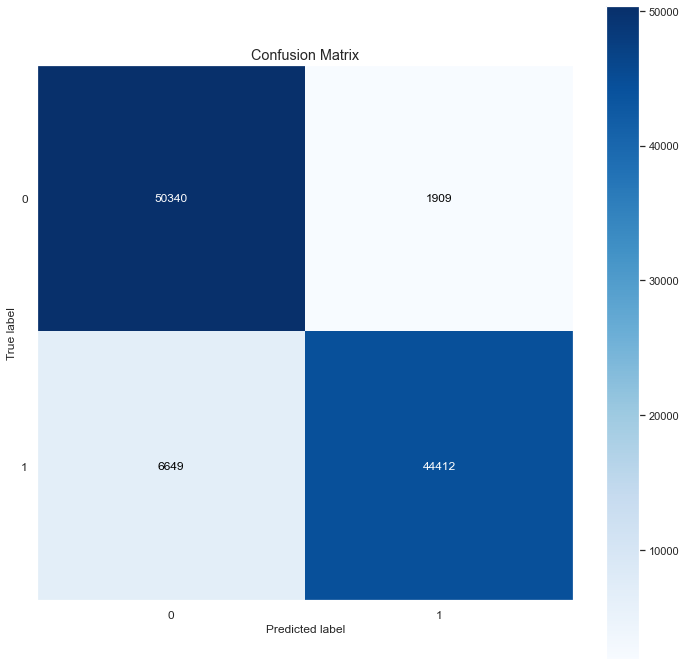

In [62]:
# Accuracy
acc_catb = accuracy_score(y_test, yhat_catb)
print('Accuracy: {}'.format(acc_catb))

# Balanced Accuracy
balanced_acc_catb = balanced_accuracy_score(y_test, yhat_catb)
print('Balanced Accuracy: {}'.format(balanced_acc_catb))

# Kappa Score
kappa_catb = cohen_kappa_score(y_test, yhat_catb)
print('Kappa Score: {}'.format(kappa_catb))

# Classification Report
print(classification_report(y_test, yhat_catb))

# Confusion matrix
plot_confusion_matrix(y_test, yhat_catb, normalize=False, figsize=(12, 12));

#### 9.2.4.2 Performance - Cross Validation

In [63]:
model = CatBoostClassifier(random_state=42)
result_catb = cross_validation(X_train, y_train, 'CatBoost Classifier', model, num_folds=5, verbose=True)
result_catb

Fold Number: 1/5
Learning rate set to 0.122651
0:	learn: 0.5678151	total: 36.8ms	remaining: 36.7s
1:	learn: 0.5034011	total: 71.6ms	remaining: 35.7s
2:	learn: 0.4570832	total: 105ms	remaining: 34.8s
3:	learn: 0.4313673	total: 142ms	remaining: 35.2s
4:	learn: 0.4215706	total: 172ms	remaining: 34.2s
5:	learn: 0.4064291	total: 210ms	remaining: 34.8s
6:	learn: 0.3977345	total: 250ms	remaining: 35.4s
7:	learn: 0.3884159	total: 283ms	remaining: 35.1s
8:	learn: 0.3832489	total: 318ms	remaining: 35s
9:	learn: 0.3797013	total: 354ms	remaining: 35s
10:	learn: 0.3765895	total: 390ms	remaining: 35.1s
11:	learn: 0.3692672	total: 435ms	remaining: 35.8s
12:	learn: 0.3641682	total: 482ms	remaining: 36.6s
13:	learn: 0.3588331	total: 520ms	remaining: 36.6s
14:	learn: 0.3530824	total: 561ms	remaining: 36.8s
15:	learn: 0.3501677	total: 596ms	remaining: 36.6s
16:	learn: 0.3478663	total: 634ms	remaining: 36.7s
17:	learn: 0.3465008	total: 673ms	remaining: 36.7s
18:	learn: 0.3434295	total: 708ms	remaining: 36

163:	learn: 0.2342592	total: 6.62s	remaining: 33.8s
164:	learn: 0.2341940	total: 6.67s	remaining: 33.8s
165:	learn: 0.2340775	total: 6.71s	remaining: 33.7s
166:	learn: 0.2337626	total: 6.75s	remaining: 33.7s
167:	learn: 0.2336891	total: 6.79s	remaining: 33.6s
168:	learn: 0.2335341	total: 6.84s	remaining: 33.6s
169:	learn: 0.2333977	total: 6.88s	remaining: 33.6s
170:	learn: 0.2333400	total: 6.92s	remaining: 33.6s
171:	learn: 0.2329163	total: 6.96s	remaining: 33.5s
172:	learn: 0.2326470	total: 7s	remaining: 33.5s
173:	learn: 0.2325212	total: 7.04s	remaining: 33.4s
174:	learn: 0.2321934	total: 7.08s	remaining: 33.4s
175:	learn: 0.2312358	total: 7.12s	remaining: 33.3s
176:	learn: 0.2306160	total: 7.16s	remaining: 33.3s
177:	learn: 0.2304999	total: 7.19s	remaining: 33.2s
178:	learn: 0.2300109	total: 7.23s	remaining: 33.2s
179:	learn: 0.2299173	total: 7.27s	remaining: 33.1s
180:	learn: 0.2297393	total: 7.31s	remaining: 33.1s
181:	learn: 0.2292983	total: 7.35s	remaining: 33s
182:	learn: 0.229

326:	learn: 0.2032821	total: 13.2s	remaining: 27.1s
327:	learn: 0.2030977	total: 13.2s	remaining: 27s
328:	learn: 0.2027198	total: 13.2s	remaining: 27s
329:	learn: 0.2026010	total: 13.3s	remaining: 26.9s
330:	learn: 0.2025540	total: 13.3s	remaining: 26.9s
331:	learn: 0.2023017	total: 13.3s	remaining: 26.8s
332:	learn: 0.2021835	total: 13.4s	remaining: 26.8s
333:	learn: 0.2020640	total: 13.4s	remaining: 26.8s
334:	learn: 0.2020244	total: 13.5s	remaining: 26.7s
335:	learn: 0.2018050	total: 13.5s	remaining: 26.7s
336:	learn: 0.2016633	total: 13.6s	remaining: 26.7s
337:	learn: 0.2016092	total: 13.6s	remaining: 26.6s
338:	learn: 0.2015228	total: 13.6s	remaining: 26.6s
339:	learn: 0.2013022	total: 13.7s	remaining: 26.5s
340:	learn: 0.2012281	total: 13.7s	remaining: 26.5s
341:	learn: 0.2012010	total: 13.7s	remaining: 26.4s
342:	learn: 0.2010901	total: 13.8s	remaining: 26.4s
343:	learn: 0.2009824	total: 13.8s	remaining: 26.4s
344:	learn: 0.2009157	total: 13.9s	remaining: 26.3s
345:	learn: 0.20

488:	learn: 0.1915226	total: 19.7s	remaining: 20.6s
489:	learn: 0.1914649	total: 19.7s	remaining: 20.5s
490:	learn: 0.1914110	total: 19.8s	remaining: 20.5s
491:	learn: 0.1913736	total: 19.8s	remaining: 20.4s
492:	learn: 0.1913309	total: 19.8s	remaining: 20.4s
493:	learn: 0.1912794	total: 19.9s	remaining: 20.4s
494:	learn: 0.1912228	total: 19.9s	remaining: 20.3s
495:	learn: 0.1911857	total: 20s	remaining: 20.3s
496:	learn: 0.1911567	total: 20s	remaining: 20.2s
497:	learn: 0.1910432	total: 20s	remaining: 20.2s
498:	learn: 0.1909722	total: 20.1s	remaining: 20.2s
499:	learn: 0.1909469	total: 20.1s	remaining: 20.1s
500:	learn: 0.1909174	total: 20.2s	remaining: 20.1s
501:	learn: 0.1908666	total: 20.2s	remaining: 20s
502:	learn: 0.1908168	total: 20.2s	remaining: 20s
503:	learn: 0.1907907	total: 20.3s	remaining: 20s
504:	learn: 0.1907476	total: 20.3s	remaining: 19.9s
505:	learn: 0.1906704	total: 20.4s	remaining: 19.9s
506:	learn: 0.1906268	total: 20.4s	remaining: 19.9s
507:	learn: 0.1905734	to

648:	learn: 0.1841746	total: 26.4s	remaining: 14.3s
649:	learn: 0.1841531	total: 26.4s	remaining: 14.2s
650:	learn: 0.1841169	total: 26.5s	remaining: 14.2s
651:	learn: 0.1840883	total: 26.5s	remaining: 14.2s
652:	learn: 0.1840646	total: 26.6s	remaining: 14.1s
653:	learn: 0.1840352	total: 26.6s	remaining: 14.1s
654:	learn: 0.1840022	total: 26.6s	remaining: 14s
655:	learn: 0.1839559	total: 26.7s	remaining: 14s
656:	learn: 0.1839098	total: 26.7s	remaining: 14s
657:	learn: 0.1838879	total: 26.8s	remaining: 13.9s
658:	learn: 0.1838618	total: 26.8s	remaining: 13.9s
659:	learn: 0.1837995	total: 26.8s	remaining: 13.8s
660:	learn: 0.1837659	total: 26.9s	remaining: 13.8s
661:	learn: 0.1837387	total: 26.9s	remaining: 13.7s
662:	learn: 0.1835363	total: 27s	remaining: 13.7s
663:	learn: 0.1835032	total: 27s	remaining: 13.7s
664:	learn: 0.1834149	total: 27.1s	remaining: 13.6s
665:	learn: 0.1832895	total: 27.1s	remaining: 13.6s
666:	learn: 0.1831052	total: 27.1s	remaining: 13.5s
667:	learn: 0.1830748	

809:	learn: 0.1773309	total: 33.1s	remaining: 7.77s
810:	learn: 0.1773098	total: 33.2s	remaining: 7.73s
811:	learn: 0.1772613	total: 33.2s	remaining: 7.69s
812:	learn: 0.1772405	total: 33.3s	remaining: 7.65s
813:	learn: 0.1772192	total: 33.3s	remaining: 7.61s
814:	learn: 0.1772073	total: 33.4s	remaining: 7.57s
815:	learn: 0.1771721	total: 33.4s	remaining: 7.53s
816:	learn: 0.1771526	total: 33.4s	remaining: 7.49s
817:	learn: 0.1771027	total: 33.5s	remaining: 7.45s
818:	learn: 0.1770753	total: 33.5s	remaining: 7.41s
819:	learn: 0.1770510	total: 33.6s	remaining: 7.37s
820:	learn: 0.1770313	total: 33.6s	remaining: 7.33s
821:	learn: 0.1769805	total: 33.7s	remaining: 7.29s
822:	learn: 0.1769529	total: 33.7s	remaining: 7.25s
823:	learn: 0.1769193	total: 33.7s	remaining: 7.21s
824:	learn: 0.1769076	total: 33.8s	remaining: 7.17s
825:	learn: 0.1768845	total: 33.8s	remaining: 7.13s
826:	learn: 0.1768460	total: 33.9s	remaining: 7.08s
827:	learn: 0.1767796	total: 33.9s	remaining: 7.04s
828:	learn: 

973:	learn: 0.1725646	total: 40.1s	remaining: 1.07s
974:	learn: 0.1725288	total: 40.1s	remaining: 1.03s
975:	learn: 0.1725144	total: 40.1s	remaining: 987ms
976:	learn: 0.1724898	total: 40.2s	remaining: 946ms
977:	learn: 0.1724683	total: 40.2s	remaining: 905ms
978:	learn: 0.1724482	total: 40.3s	remaining: 864ms
979:	learn: 0.1724289	total: 40.3s	remaining: 823ms
980:	learn: 0.1724068	total: 40.4s	remaining: 782ms
981:	learn: 0.1723903	total: 40.4s	remaining: 741ms
982:	learn: 0.1723303	total: 40.4s	remaining: 699ms
983:	learn: 0.1723077	total: 40.5s	remaining: 658ms
984:	learn: 0.1722861	total: 40.5s	remaining: 617ms
985:	learn: 0.1722704	total: 40.6s	remaining: 576ms
986:	learn: 0.1722590	total: 40.6s	remaining: 535ms
987:	learn: 0.1722480	total: 40.6s	remaining: 494ms
988:	learn: 0.1722311	total: 40.7s	remaining: 453ms
989:	learn: 0.1722156	total: 40.7s	remaining: 412ms
990:	learn: 0.1722015	total: 40.8s	remaining: 370ms
991:	learn: 0.1721814	total: 40.8s	remaining: 329ms
992:	learn: 

137:	learn: 0.2436369	total: 5.43s	remaining: 33.9s
138:	learn: 0.2434071	total: 5.47s	remaining: 33.9s
139:	learn: 0.2431591	total: 5.51s	remaining: 33.9s
140:	learn: 0.2429759	total: 5.55s	remaining: 33.8s
141:	learn: 0.2427331	total: 5.59s	remaining: 33.8s
142:	learn: 0.2425572	total: 5.63s	remaining: 33.7s
143:	learn: 0.2420305	total: 5.67s	remaining: 33.7s
144:	learn: 0.2417647	total: 5.71s	remaining: 33.7s
145:	learn: 0.2415581	total: 5.75s	remaining: 33.6s
146:	learn: 0.2413827	total: 5.79s	remaining: 33.6s
147:	learn: 0.2409412	total: 5.82s	remaining: 33.5s
148:	learn: 0.2407785	total: 5.86s	remaining: 33.5s
149:	learn: 0.2405018	total: 5.9s	remaining: 33.4s
150:	learn: 0.2402089	total: 5.94s	remaining: 33.4s
151:	learn: 0.2398767	total: 5.98s	remaining: 33.4s
152:	learn: 0.2396407	total: 6.02s	remaining: 33.4s
153:	learn: 0.2386446	total: 6.06s	remaining: 33.3s
154:	learn: 0.2384166	total: 6.1s	remaining: 33.2s
155:	learn: 0.2378942	total: 6.13s	remaining: 33.2s
156:	learn: 0.

299:	learn: 0.2065349	total: 12.1s	remaining: 28.2s
300:	learn: 0.2064401	total: 12.2s	remaining: 28.2s
301:	learn: 0.2062712	total: 12.2s	remaining: 28.2s
302:	learn: 0.2061521	total: 12.3s	remaining: 28.2s
303:	learn: 0.2060756	total: 12.3s	remaining: 28.2s
304:	learn: 0.2059950	total: 12.3s	remaining: 28.1s
305:	learn: 0.2059535	total: 12.4s	remaining: 28.1s
306:	learn: 0.2057481	total: 12.4s	remaining: 28s
307:	learn: 0.2056209	total: 12.5s	remaining: 28s
308:	learn: 0.2054601	total: 12.5s	remaining: 28s
309:	learn: 0.2053445	total: 12.6s	remaining: 27.9s
310:	learn: 0.2053161	total: 12.6s	remaining: 27.9s
311:	learn: 0.2051201	total: 12.6s	remaining: 27.9s
312:	learn: 0.2050126	total: 12.7s	remaining: 27.9s
313:	learn: 0.2049160	total: 12.7s	remaining: 27.8s
314:	learn: 0.2047340	total: 12.8s	remaining: 27.8s
315:	learn: 0.2046729	total: 12.8s	remaining: 27.7s
316:	learn: 0.2046145	total: 12.9s	remaining: 27.7s
317:	learn: 0.2044811	total: 12.9s	remaining: 27.7s
318:	learn: 0.2044

459:	learn: 0.1929970	total: 19.4s	remaining: 22.8s
460:	learn: 0.1929057	total: 19.5s	remaining: 22.8s
461:	learn: 0.1928116	total: 19.5s	remaining: 22.7s
462:	learn: 0.1927687	total: 19.6s	remaining: 22.7s
463:	learn: 0.1927457	total: 19.6s	remaining: 22.7s
464:	learn: 0.1927142	total: 19.7s	remaining: 22.6s
465:	learn: 0.1925900	total: 19.7s	remaining: 22.6s
466:	learn: 0.1923691	total: 19.8s	remaining: 22.6s
467:	learn: 0.1922907	total: 19.8s	remaining: 22.5s
468:	learn: 0.1922006	total: 19.9s	remaining: 22.5s
469:	learn: 0.1918809	total: 19.9s	remaining: 22.4s
470:	learn: 0.1917871	total: 20s	remaining: 22.4s
471:	learn: 0.1917230	total: 20s	remaining: 22.4s
472:	learn: 0.1916776	total: 20s	remaining: 22.3s
473:	learn: 0.1916129	total: 20.1s	remaining: 22.3s
474:	learn: 0.1915717	total: 20.1s	remaining: 22.3s
475:	learn: 0.1913988	total: 20.2s	remaining: 22.2s
476:	learn: 0.1913581	total: 20.2s	remaining: 22.2s
477:	learn: 0.1912946	total: 20.3s	remaining: 22.1s
478:	learn: 0.1912

619:	learn: 0.1843834	total: 26.3s	remaining: 16.1s
620:	learn: 0.1843441	total: 26.4s	remaining: 16.1s
621:	learn: 0.1843213	total: 26.4s	remaining: 16s
622:	learn: 0.1842798	total: 26.4s	remaining: 16s
623:	learn: 0.1842563	total: 26.5s	remaining: 16s
624:	learn: 0.1842250	total: 26.5s	remaining: 15.9s
625:	learn: 0.1842103	total: 26.5s	remaining: 15.9s
626:	learn: 0.1841956	total: 26.6s	remaining: 15.8s
627:	learn: 0.1840295	total: 26.6s	remaining: 15.8s
628:	learn: 0.1836902	total: 26.7s	remaining: 15.7s
629:	learn: 0.1836306	total: 26.7s	remaining: 15.7s
630:	learn: 0.1833896	total: 26.7s	remaining: 15.6s
631:	learn: 0.1831462	total: 26.8s	remaining: 15.6s
632:	learn: 0.1831148	total: 26.8s	remaining: 15.6s
633:	learn: 0.1830685	total: 26.9s	remaining: 15.5s
634:	learn: 0.1830392	total: 26.9s	remaining: 15.5s
635:	learn: 0.1830119	total: 26.9s	remaining: 15.4s
636:	learn: 0.1829752	total: 27s	remaining: 15.4s
637:	learn: 0.1829135	total: 27s	remaining: 15.3s
638:	learn: 0.1828838	

783:	learn: 0.1767706	total: 33s	remaining: 9.1s
784:	learn: 0.1767028	total: 33.1s	remaining: 9.06s
785:	learn: 0.1766854	total: 33.1s	remaining: 9.02s
786:	learn: 0.1766534	total: 33.2s	remaining: 8.97s
787:	learn: 0.1766090	total: 33.2s	remaining: 8.93s
788:	learn: 0.1765804	total: 33.2s	remaining: 8.89s
789:	learn: 0.1765511	total: 33.3s	remaining: 8.85s
790:	learn: 0.1765225	total: 33.3s	remaining: 8.8s
791:	learn: 0.1765045	total: 33.4s	remaining: 8.76s
792:	learn: 0.1764829	total: 33.4s	remaining: 8.71s
793:	learn: 0.1764652	total: 33.4s	remaining: 8.67s
794:	learn: 0.1764189	total: 33.5s	remaining: 8.63s
795:	learn: 0.1763888	total: 33.5s	remaining: 8.59s
796:	learn: 0.1763576	total: 33.6s	remaining: 8.55s
797:	learn: 0.1763330	total: 33.6s	remaining: 8.51s
798:	learn: 0.1763025	total: 33.7s	remaining: 8.47s
799:	learn: 0.1762839	total: 33.7s	remaining: 8.43s
800:	learn: 0.1762658	total: 33.7s	remaining: 8.38s
801:	learn: 0.1762511	total: 33.8s	remaining: 8.34s
802:	learn: 0.17

942:	learn: 0.1720513	total: 39.6s	remaining: 2.4s
943:	learn: 0.1720292	total: 39.7s	remaining: 2.35s
944:	learn: 0.1720102	total: 39.7s	remaining: 2.31s
945:	learn: 0.1719887	total: 39.8s	remaining: 2.27s
946:	learn: 0.1719646	total: 39.8s	remaining: 2.23s
947:	learn: 0.1719461	total: 39.8s	remaining: 2.18s
948:	learn: 0.1719349	total: 39.9s	remaining: 2.14s
949:	learn: 0.1718895	total: 39.9s	remaining: 2.1s
950:	learn: 0.1718647	total: 40s	remaining: 2.06s
951:	learn: 0.1718507	total: 40s	remaining: 2.02s
952:	learn: 0.1718238	total: 40s	remaining: 1.97s
953:	learn: 0.1718056	total: 40.1s	remaining: 1.93s
954:	learn: 0.1717781	total: 40.1s	remaining: 1.89s
955:	learn: 0.1717505	total: 40.1s	remaining: 1.85s
956:	learn: 0.1717306	total: 40.2s	remaining: 1.8s
957:	learn: 0.1717008	total: 40.2s	remaining: 1.76s
958:	learn: 0.1716840	total: 40.3s	remaining: 1.72s
959:	learn: 0.1716657	total: 40.3s	remaining: 1.68s
960:	learn: 0.1716226	total: 40.3s	remaining: 1.64s
961:	learn: 0.1716052

102:	learn: 0.2656230	total: 3.91s	remaining: 34.1s
103:	learn: 0.2652470	total: 3.95s	remaining: 34s
104:	learn: 0.2647555	total: 3.98s	remaining: 33.9s
105:	learn: 0.2642985	total: 4.01s	remaining: 33.9s
106:	learn: 0.2636001	total: 4.05s	remaining: 33.8s
107:	learn: 0.2631125	total: 4.09s	remaining: 33.8s
108:	learn: 0.2623187	total: 4.14s	remaining: 33.8s
109:	learn: 0.2617725	total: 4.19s	remaining: 33.9s
110:	learn: 0.2615010	total: 4.23s	remaining: 33.9s
111:	learn: 0.2608211	total: 4.27s	remaining: 33.9s
112:	learn: 0.2594800	total: 4.31s	remaining: 33.9s
113:	learn: 0.2591968	total: 4.36s	remaining: 33.9s
114:	learn: 0.2583710	total: 4.4s	remaining: 33.8s
115:	learn: 0.2577694	total: 4.44s	remaining: 33.8s
116:	learn: 0.2576082	total: 4.48s	remaining: 33.8s
117:	learn: 0.2573797	total: 4.52s	remaining: 33.8s
118:	learn: 0.2571141	total: 4.56s	remaining: 33.8s
119:	learn: 0.2565674	total: 4.6s	remaining: 33.7s
120:	learn: 0.2563693	total: 4.64s	remaining: 33.7s
121:	learn: 0.25

263:	learn: 0.2143190	total: 11s	remaining: 30.6s
264:	learn: 0.2142237	total: 11s	remaining: 30.5s
265:	learn: 0.2139847	total: 11s	remaining: 30.5s
266:	learn: 0.2137778	total: 11.1s	remaining: 30.5s
267:	learn: 0.2137169	total: 11.1s	remaining: 30.4s
268:	learn: 0.2134681	total: 11.2s	remaining: 30.4s
269:	learn: 0.2132497	total: 11.2s	remaining: 30.4s
270:	learn: 0.2130968	total: 11.3s	remaining: 30.4s
271:	learn: 0.2128539	total: 11.3s	remaining: 30.4s
272:	learn: 0.2127677	total: 11.4s	remaining: 30.3s
273:	learn: 0.2125741	total: 11.4s	remaining: 30.3s
274:	learn: 0.2124897	total: 11.5s	remaining: 30.3s
275:	learn: 0.2124352	total: 11.5s	remaining: 30.2s
276:	learn: 0.2123464	total: 11.6s	remaining: 30.2s
277:	learn: 0.2122531	total: 11.6s	remaining: 30.2s
278:	learn: 0.2121668	total: 11.7s	remaining: 30.1s
279:	learn: 0.2119679	total: 11.7s	remaining: 30.1s
280:	learn: 0.2118480	total: 11.7s	remaining: 30s
281:	learn: 0.2117836	total: 11.8s	remaining: 30s
282:	learn: 0.2116933	

422:	learn: 0.1958983	total: 18.3s	remaining: 25s
423:	learn: 0.1957465	total: 18.4s	remaining: 25s
424:	learn: 0.1956633	total: 18.4s	remaining: 25s
425:	learn: 0.1955869	total: 18.5s	remaining: 24.9s
426:	learn: 0.1955306	total: 18.5s	remaining: 24.9s
427:	learn: 0.1953018	total: 18.6s	remaining: 24.9s
428:	learn: 0.1951811	total: 18.6s	remaining: 24.8s
429:	learn: 0.1951251	total: 18.7s	remaining: 24.8s
430:	learn: 0.1950640	total: 18.7s	remaining: 24.7s
431:	learn: 0.1949712	total: 18.8s	remaining: 24.7s
432:	learn: 0.1949430	total: 18.8s	remaining: 24.7s
433:	learn: 0.1948859	total: 18.9s	remaining: 24.6s
434:	learn: 0.1948555	total: 18.9s	remaining: 24.6s
435:	learn: 0.1947691	total: 19s	remaining: 24.6s
436:	learn: 0.1947221	total: 19s	remaining: 24.5s
437:	learn: 0.1946706	total: 19.1s	remaining: 24.5s
438:	learn: 0.1945428	total: 19.1s	remaining: 24.4s
439:	learn: 0.1944601	total: 19.2s	remaining: 24.4s
440:	learn: 0.1944221	total: 19.2s	remaining: 24.4s
441:	learn: 0.1942969	

585:	learn: 0.1861569	total: 26s	remaining: 18.4s
586:	learn: 0.1860823	total: 26.1s	remaining: 18.3s
587:	learn: 0.1860517	total: 26.1s	remaining: 18.3s
588:	learn: 0.1860126	total: 26.2s	remaining: 18.2s
589:	learn: 0.1859770	total: 26.2s	remaining: 18.2s
590:	learn: 0.1859304	total: 26.2s	remaining: 18.2s
591:	learn: 0.1858855	total: 26.3s	remaining: 18.1s
592:	learn: 0.1858054	total: 26.3s	remaining: 18.1s
593:	learn: 0.1857620	total: 26.4s	remaining: 18s
594:	learn: 0.1857323	total: 26.4s	remaining: 18s
595:	learn: 0.1857094	total: 26.5s	remaining: 17.9s
596:	learn: 0.1856818	total: 26.5s	remaining: 17.9s
597:	learn: 0.1856562	total: 26.5s	remaining: 17.8s
598:	learn: 0.1856273	total: 26.6s	remaining: 17.8s
599:	learn: 0.1855901	total: 26.6s	remaining: 17.8s
600:	learn: 0.1855611	total: 26.7s	remaining: 17.7s
601:	learn: 0.1854869	total: 26.7s	remaining: 17.7s
602:	learn: 0.1854621	total: 26.8s	remaining: 17.6s
603:	learn: 0.1853722	total: 26.8s	remaining: 17.6s
604:	learn: 0.1853

746:	learn: 0.1798533	total: 33s	remaining: 11.2s
747:	learn: 0.1798338	total: 33s	remaining: 11.1s
748:	learn: 0.1798137	total: 33.1s	remaining: 11.1s
749:	learn: 0.1797827	total: 33.1s	remaining: 11s
750:	learn: 0.1797660	total: 33.2s	remaining: 11s
751:	learn: 0.1797152	total: 33.2s	remaining: 11s
752:	learn: 0.1796839	total: 33.3s	remaining: 10.9s
753:	learn: 0.1796582	total: 33.3s	remaining: 10.9s
754:	learn: 0.1796313	total: 33.4s	remaining: 10.8s
755:	learn: 0.1796113	total: 33.4s	remaining: 10.8s
756:	learn: 0.1795900	total: 33.4s	remaining: 10.7s
757:	learn: 0.1795479	total: 33.5s	remaining: 10.7s
758:	learn: 0.1795115	total: 33.5s	remaining: 10.6s
759:	learn: 0.1794748	total: 33.6s	remaining: 10.6s
760:	learn: 0.1794529	total: 33.6s	remaining: 10.6s
761:	learn: 0.1793843	total: 33.7s	remaining: 10.5s
762:	learn: 0.1793620	total: 33.7s	remaining: 10.5s
763:	learn: 0.1793429	total: 33.8s	remaining: 10.4s
764:	learn: 0.1793031	total: 33.8s	remaining: 10.4s
765:	learn: 0.1792672	

907:	learn: 0.1749793	total: 40.5s	remaining: 4.11s
908:	learn: 0.1749643	total: 40.6s	remaining: 4.06s
909:	learn: 0.1749444	total: 40.6s	remaining: 4.02s
910:	learn: 0.1748146	total: 40.7s	remaining: 3.97s
911:	learn: 0.1747928	total: 40.7s	remaining: 3.93s
912:	learn: 0.1747662	total: 40.8s	remaining: 3.88s
913:	learn: 0.1747376	total: 40.8s	remaining: 3.84s
914:	learn: 0.1746550	total: 40.9s	remaining: 3.8s
915:	learn: 0.1746115	total: 40.9s	remaining: 3.75s
916:	learn: 0.1745871	total: 41s	remaining: 3.71s
917:	learn: 0.1745653	total: 41s	remaining: 3.66s
918:	learn: 0.1745432	total: 41.1s	remaining: 3.62s
919:	learn: 0.1745259	total: 41.1s	remaining: 3.58s
920:	learn: 0.1745063	total: 41.2s	remaining: 3.53s
921:	learn: 0.1744876	total: 41.2s	remaining: 3.49s
922:	learn: 0.1744747	total: 41.3s	remaining: 3.44s
923:	learn: 0.1744646	total: 41.3s	remaining: 3.4s
924:	learn: 0.1744481	total: 41.3s	remaining: 3.35s
925:	learn: 0.1744329	total: 41.4s	remaining: 3.31s
926:	learn: 0.1744

67:	learn: 0.2823226	total: 2.97s	remaining: 40.7s
68:	learn: 0.2819449	total: 3.01s	remaining: 40.6s
69:	learn: 0.2816260	total: 3.05s	remaining: 40.6s
70:	learn: 0.2812614	total: 3.1s	remaining: 40.5s
71:	learn: 0.2806897	total: 3.14s	remaining: 40.4s
72:	learn: 0.2805427	total: 3.18s	remaining: 40.4s
73:	learn: 0.2799376	total: 3.23s	remaining: 40.4s
74:	learn: 0.2792305	total: 3.28s	remaining: 40.4s
75:	learn: 0.2786234	total: 3.32s	remaining: 40.4s
76:	learn: 0.2781087	total: 3.37s	remaining: 40.4s
77:	learn: 0.2772592	total: 3.42s	remaining: 40.4s
78:	learn: 0.2757777	total: 3.46s	remaining: 40.4s
79:	learn: 0.2752794	total: 3.5s	remaining: 40.3s
80:	learn: 0.2750269	total: 3.55s	remaining: 40.3s
81:	learn: 0.2746026	total: 3.59s	remaining: 40.2s
82:	learn: 0.2742713	total: 3.63s	remaining: 40.1s
83:	learn: 0.2738257	total: 3.69s	remaining: 40.2s
84:	learn: 0.2734888	total: 3.75s	remaining: 40.3s
85:	learn: 0.2718961	total: 3.79s	remaining: 40.3s
86:	learn: 0.2714149	total: 3.84s

230:	learn: 0.2192363	total: 10.8s	remaining: 35.9s
231:	learn: 0.2190729	total: 10.8s	remaining: 35.8s
232:	learn: 0.2188984	total: 10.9s	remaining: 35.8s
233:	learn: 0.2188170	total: 10.9s	remaining: 35.7s
234:	learn: 0.2185837	total: 11s	remaining: 35.7s
235:	learn: 0.2184928	total: 11s	remaining: 35.7s
236:	learn: 0.2182953	total: 11.1s	remaining: 35.6s
237:	learn: 0.2179115	total: 11.1s	remaining: 35.6s
238:	learn: 0.2173664	total: 11.2s	remaining: 35.6s
239:	learn: 0.2169841	total: 11.2s	remaining: 35.6s
240:	learn: 0.2164738	total: 11.3s	remaining: 35.6s
241:	learn: 0.2160920	total: 11.4s	remaining: 35.6s
242:	learn: 0.2158939	total: 11.4s	remaining: 35.6s
243:	learn: 0.2156113	total: 11.5s	remaining: 35.5s
244:	learn: 0.2154299	total: 11.5s	remaining: 35.5s
245:	learn: 0.2152460	total: 11.6s	remaining: 35.5s
246:	learn: 0.2150174	total: 11.6s	remaining: 35.4s
247:	learn: 0.2146262	total: 11.7s	remaining: 35.4s
248:	learn: 0.2141196	total: 11.7s	remaining: 35.3s
249:	learn: 0.21

391:	learn: 0.1981145	total: 18.5s	remaining: 28.7s
392:	learn: 0.1980750	total: 18.6s	remaining: 28.7s
393:	learn: 0.1980266	total: 18.6s	remaining: 28.6s
394:	learn: 0.1979899	total: 18.7s	remaining: 28.6s
395:	learn: 0.1979492	total: 18.7s	remaining: 28.6s
396:	learn: 0.1978063	total: 18.8s	remaining: 28.5s
397:	learn: 0.1977821	total: 18.8s	remaining: 28.5s
398:	learn: 0.1977500	total: 18.9s	remaining: 28.4s
399:	learn: 0.1977132	total: 18.9s	remaining: 28.3s
400:	learn: 0.1976645	total: 18.9s	remaining: 28.3s
401:	learn: 0.1975728	total: 19s	remaining: 28.3s
402:	learn: 0.1975003	total: 19s	remaining: 28.2s
403:	learn: 0.1973430	total: 19.1s	remaining: 28.2s
404:	learn: 0.1971977	total: 19.1s	remaining: 28.1s
405:	learn: 0.1969563	total: 19.2s	remaining: 28.1s
406:	learn: 0.1968523	total: 19.2s	remaining: 28s
407:	learn: 0.1966831	total: 19.3s	remaining: 28s
408:	learn: 0.1965645	total: 19.3s	remaining: 27.9s
409:	learn: 0.1964685	total: 19.4s	remaining: 27.9s
410:	learn: 0.196392

552:	learn: 0.1879918	total: 25.7s	remaining: 20.8s
553:	learn: 0.1879685	total: 25.7s	remaining: 20.7s
554:	learn: 0.1879435	total: 25.8s	remaining: 20.7s
555:	learn: 0.1879232	total: 25.8s	remaining: 20.6s
556:	learn: 0.1878865	total: 25.9s	remaining: 20.6s
557:	learn: 0.1878418	total: 25.9s	remaining: 20.5s
558:	learn: 0.1878150	total: 26s	remaining: 20.5s
559:	learn: 0.1877191	total: 26s	remaining: 20.4s
560:	learn: 0.1876681	total: 26.1s	remaining: 20.4s
561:	learn: 0.1876216	total: 26.1s	remaining: 20.3s
562:	learn: 0.1875988	total: 26.1s	remaining: 20.3s
563:	learn: 0.1875486	total: 26.2s	remaining: 20.2s
564:	learn: 0.1875082	total: 26.2s	remaining: 20.2s
565:	learn: 0.1874463	total: 26.3s	remaining: 20.1s
566:	learn: 0.1874016	total: 26.3s	remaining: 20.1s
567:	learn: 0.1873770	total: 26.4s	remaining: 20s
568:	learn: 0.1873542	total: 26.4s	remaining: 20s
569:	learn: 0.1873390	total: 26.4s	remaining: 19.9s
570:	learn: 0.1873017	total: 26.5s	remaining: 19.9s
571:	learn: 0.187240

714:	learn: 0.1812052	total: 32.7s	remaining: 13s
715:	learn: 0.1811247	total: 32.8s	remaining: 13s
716:	learn: 0.1810914	total: 32.8s	remaining: 12.9s
717:	learn: 0.1810517	total: 32.9s	remaining: 12.9s
718:	learn: 0.1810156	total: 32.9s	remaining: 12.9s
719:	learn: 0.1809915	total: 33s	remaining: 12.8s
720:	learn: 0.1809615	total: 33s	remaining: 12.8s
721:	learn: 0.1809409	total: 33.1s	remaining: 12.7s
722:	learn: 0.1809151	total: 33.1s	remaining: 12.7s
723:	learn: 0.1808651	total: 33.2s	remaining: 12.7s
724:	learn: 0.1807923	total: 33.2s	remaining: 12.6s
725:	learn: 0.1807597	total: 33.3s	remaining: 12.6s
726:	learn: 0.1806465	total: 33.3s	remaining: 12.5s
727:	learn: 0.1806291	total: 33.4s	remaining: 12.5s
728:	learn: 0.1805904	total: 33.4s	remaining: 12.4s
729:	learn: 0.1805679	total: 33.5s	remaining: 12.4s
730:	learn: 0.1805064	total: 33.5s	remaining: 12.3s
731:	learn: 0.1804877	total: 33.6s	remaining: 12.3s
732:	learn: 0.1804536	total: 33.6s	remaining: 12.2s
733:	learn: 0.180429

878:	learn: 0.1752262	total: 40.1s	remaining: 5.52s
879:	learn: 0.1751665	total: 40.2s	remaining: 5.47s
880:	learn: 0.1751511	total: 40.2s	remaining: 5.43s
881:	learn: 0.1751291	total: 40.2s	remaining: 5.38s
882:	learn: 0.1751034	total: 40.3s	remaining: 5.34s
883:	learn: 0.1750816	total: 40.3s	remaining: 5.29s
884:	learn: 0.1750653	total: 40.4s	remaining: 5.25s
885:	learn: 0.1750345	total: 40.4s	remaining: 5.2s
886:	learn: 0.1750041	total: 40.5s	remaining: 5.16s
887:	learn: 0.1749817	total: 40.5s	remaining: 5.11s
888:	learn: 0.1749534	total: 40.6s	remaining: 5.06s
889:	learn: 0.1749349	total: 40.6s	remaining: 5.02s
890:	learn: 0.1748928	total: 40.6s	remaining: 4.97s
891:	learn: 0.1748774	total: 40.7s	remaining: 4.92s
892:	learn: 0.1748560	total: 40.7s	remaining: 4.88s
893:	learn: 0.1748389	total: 40.7s	remaining: 4.83s
894:	learn: 0.1747791	total: 40.8s	remaining: 4.79s
895:	learn: 0.1747616	total: 40.9s	remaining: 4.74s
896:	learn: 0.1747254	total: 40.9s	remaining: 4.7s
897:	learn: 0.

37:	learn: 0.3123553	total: 1.64s	remaining: 41.5s
38:	learn: 0.3112508	total: 1.68s	remaining: 41.4s
39:	learn: 0.3106992	total: 1.72s	remaining: 41.2s
40:	learn: 0.3094057	total: 1.76s	remaining: 41.1s
41:	learn: 0.3085112	total: 1.8s	remaining: 41s
42:	learn: 0.3065900	total: 1.84s	remaining: 40.9s
43:	learn: 0.3059190	total: 1.88s	remaining: 40.9s
44:	learn: 0.3035706	total: 1.92s	remaining: 40.8s
45:	learn: 0.3012747	total: 1.97s	remaining: 40.9s
46:	learn: 0.3006658	total: 2.01s	remaining: 40.7s
47:	learn: 0.2997446	total: 2.05s	remaining: 40.7s
48:	learn: 0.2986366	total: 2.09s	remaining: 40.5s
49:	learn: 0.2976610	total: 2.13s	remaining: 40.5s
50:	learn: 0.2951019	total: 2.17s	remaining: 40.4s
51:	learn: 0.2945954	total: 2.21s	remaining: 40.4s
52:	learn: 0.2937568	total: 2.25s	remaining: 40.3s
53:	learn: 0.2928296	total: 2.3s	remaining: 40.3s
54:	learn: 0.2920347	total: 2.34s	remaining: 40.2s
55:	learn: 0.2912609	total: 2.38s	remaining: 40.2s
56:	learn: 0.2901919	total: 2.43s	r

203:	learn: 0.2250202	total: 8.43s	remaining: 32.9s
204:	learn: 0.2249457	total: 8.46s	remaining: 32.8s
205:	learn: 0.2246648	total: 8.5s	remaining: 32.8s
206:	learn: 0.2240224	total: 8.54s	remaining: 32.7s
207:	learn: 0.2238822	total: 8.57s	remaining: 32.6s
208:	learn: 0.2237517	total: 8.61s	remaining: 32.6s
209:	learn: 0.2237034	total: 8.65s	remaining: 32.5s
210:	learn: 0.2232904	total: 8.68s	remaining: 32.5s
211:	learn: 0.2231493	total: 8.72s	remaining: 32.4s
212:	learn: 0.2229604	total: 8.76s	remaining: 32.4s
213:	learn: 0.2228573	total: 8.8s	remaining: 32.3s
214:	learn: 0.2224012	total: 8.84s	remaining: 32.3s
215:	learn: 0.2223293	total: 8.89s	remaining: 32.3s
216:	learn: 0.2221906	total: 8.95s	remaining: 32.3s
217:	learn: 0.2220717	total: 8.99s	remaining: 32.2s
218:	learn: 0.2219071	total: 9.03s	remaining: 32.2s
219:	learn: 0.2217313	total: 9.08s	remaining: 32.2s
220:	learn: 0.2216155	total: 9.13s	remaining: 32.2s
221:	learn: 0.2214421	total: 9.18s	remaining: 32.2s
222:	learn: 0.

365:	learn: 0.2026663	total: 14.8s	remaining: 25.7s
366:	learn: 0.2025751	total: 14.9s	remaining: 25.7s
367:	learn: 0.2024293	total: 14.9s	remaining: 25.6s
368:	learn: 0.2023934	total: 14.9s	remaining: 25.6s
369:	learn: 0.2022934	total: 15s	remaining: 25.5s
370:	learn: 0.2022374	total: 15s	remaining: 25.5s
371:	learn: 0.2018043	total: 15.1s	remaining: 25.4s
372:	learn: 0.2017527	total: 15.1s	remaining: 25.4s
373:	learn: 0.2016732	total: 15.1s	remaining: 25.3s
374:	learn: 0.2016363	total: 15.2s	remaining: 25.3s
375:	learn: 0.2015992	total: 15.2s	remaining: 25.2s
376:	learn: 0.2015438	total: 15.2s	remaining: 25.2s
377:	learn: 0.2015029	total: 15.3s	remaining: 25.1s
378:	learn: 0.2014157	total: 15.3s	remaining: 25.1s
379:	learn: 0.2013021	total: 15.4s	remaining: 25.1s
380:	learn: 0.2012382	total: 15.4s	remaining: 25s
381:	learn: 0.2011392	total: 15.4s	remaining: 25s
382:	learn: 0.2010963	total: 15.5s	remaining: 24.9s
383:	learn: 0.2009915	total: 15.5s	remaining: 24.9s
384:	learn: 0.200955

529:	learn: 0.1896089	total: 21.6s	remaining: 19.1s
530:	learn: 0.1895856	total: 21.6s	remaining: 19.1s
531:	learn: 0.1895342	total: 21.7s	remaining: 19.1s
532:	learn: 0.1894459	total: 21.7s	remaining: 19s
533:	learn: 0.1893875	total: 21.7s	remaining: 19s
534:	learn: 0.1893485	total: 21.8s	remaining: 18.9s
535:	learn: 0.1893249	total: 21.8s	remaining: 18.9s
536:	learn: 0.1893062	total: 21.9s	remaining: 18.9s
537:	learn: 0.1892804	total: 21.9s	remaining: 18.8s
538:	learn: 0.1892431	total: 21.9s	remaining: 18.8s
539:	learn: 0.1891449	total: 22s	remaining: 18.7s
540:	learn: 0.1890472	total: 22s	remaining: 18.7s
541:	learn: 0.1890012	total: 22.1s	remaining: 18.6s
542:	learn: 0.1889621	total: 22.1s	remaining: 18.6s
543:	learn: 0.1889361	total: 22.1s	remaining: 18.6s
544:	learn: 0.1888797	total: 22.2s	remaining: 18.5s
545:	learn: 0.1888505	total: 22.2s	remaining: 18.5s
546:	learn: 0.1887710	total: 22.3s	remaining: 18.4s
547:	learn: 0.1887005	total: 22.3s	remaining: 18.4s
548:	learn: 0.188659

689:	learn: 0.1824889	total: 28.7s	remaining: 12.9s
690:	learn: 0.1824583	total: 28.7s	remaining: 12.9s
691:	learn: 0.1824307	total: 28.8s	remaining: 12.8s
692:	learn: 0.1824108	total: 28.8s	remaining: 12.8s
693:	learn: 0.1823923	total: 28.9s	remaining: 12.7s
694:	learn: 0.1823619	total: 28.9s	remaining: 12.7s
695:	learn: 0.1823321	total: 28.9s	remaining: 12.6s
696:	learn: 0.1822228	total: 29s	remaining: 12.6s
697:	learn: 0.1821714	total: 29s	remaining: 12.6s
698:	learn: 0.1821366	total: 29.1s	remaining: 12.5s
699:	learn: 0.1820937	total: 29.1s	remaining: 12.5s
700:	learn: 0.1820473	total: 29.1s	remaining: 12.4s
701:	learn: 0.1819531	total: 29.2s	remaining: 12.4s
702:	learn: 0.1819220	total: 29.2s	remaining: 12.3s
703:	learn: 0.1818888	total: 29.3s	remaining: 12.3s
704:	learn: 0.1818565	total: 29.3s	remaining: 12.3s
705:	learn: 0.1818266	total: 29.3s	remaining: 12.2s
706:	learn: 0.1818026	total: 29.4s	remaining: 12.2s
707:	learn: 0.1817717	total: 29.4s	remaining: 12.1s
708:	learn: 0.18

849:	learn: 0.1766569	total: 35.1s	remaining: 6.19s
850:	learn: 0.1766305	total: 35.1s	remaining: 6.15s
851:	learn: 0.1766049	total: 35.2s	remaining: 6.11s
852:	learn: 0.1765662	total: 35.2s	remaining: 6.07s
853:	learn: 0.1765271	total: 35.3s	remaining: 6.03s
854:	learn: 0.1765116	total: 35.3s	remaining: 5.99s
855:	learn: 0.1764882	total: 35.3s	remaining: 5.94s
856:	learn: 0.1764688	total: 35.4s	remaining: 5.9s
857:	learn: 0.1764546	total: 35.4s	remaining: 5.86s
858:	learn: 0.1764376	total: 35.4s	remaining: 5.82s
859:	learn: 0.1763893	total: 35.5s	remaining: 5.78s
860:	learn: 0.1763690	total: 35.5s	remaining: 5.73s
861:	learn: 0.1763395	total: 35.6s	remaining: 5.69s
862:	learn: 0.1763146	total: 35.6s	remaining: 5.65s
863:	learn: 0.1762902	total: 35.6s	remaining: 5.61s
864:	learn: 0.1762768	total: 35.7s	remaining: 5.57s
865:	learn: 0.1762574	total: 35.7s	remaining: 5.53s
866:	learn: 0.1762369	total: 35.8s	remaining: 5.49s
867:	learn: 0.1761746	total: 35.8s	remaining: 5.44s
868:	learn: 0

,Model Name,Precision CV,Recall CV,F1 Score CV,Kappa CV,Balanced Accuracy,Average Precision Score CV,ROC AUC CV
0,CatBoost Classifier,0.9531 +/- 0.002,0.8713 +/- 0.0014,0.9103 +/- 0.0007,0.8302 +/- 0.0014,0.9147 +/- 0.0007,0.9797 +/- 0.0002,0.9771 +/- 0.0003


### 9.2.5 Logistic Regression

In [64]:
lr = LogisticRegression(max_iter=220, random_state=28)
lr.fit(X_train, y_train)

# Prediction
yhat_lr = lr.predict(X_test)

#### 9.2.5.1 Performance

Accuracy: 0.7837866615042106
Balanced Accuracy: 0.7856733975918491
Kappa Score: 0.56916651071161
              precision    recall  f1-score   support

           0       0.93      0.62      0.74     52249
           1       0.71      0.95      0.81     51061

    accuracy                           0.78    103310
   macro avg       0.82      0.79      0.78    103310
weighted avg       0.82      0.78      0.78    103310



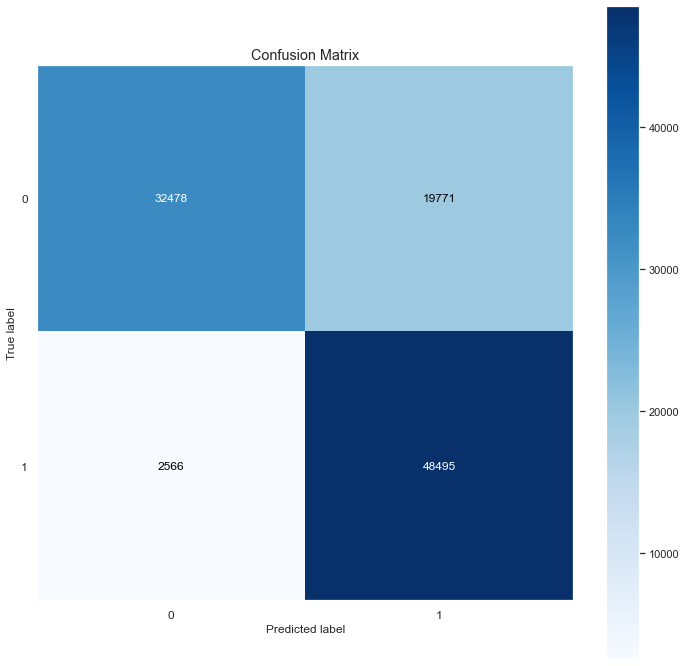

In [65]:
# Accuracy
acc_lr = accuracy_score(y_test, yhat_lr)
print('Accuracy: {}'.format(acc_lr))

# Balanced Accuracy
balanced_acc_lr = balanced_accuracy_score(y_test, yhat_lr)
print('Balanced Accuracy: {}'.format(balanced_acc_lr))

# Kappa Score
kappa_lr = cohen_kappa_score(y_test, yhat_lr)
print('Kappa Score: {}'.format(kappa_lr))

# Classification Report
print(classification_report(y_test, yhat_lr))

# Confusion matrix
plot_confusion_matrix(y_test, yhat_lr, normalize=False, figsize=(12, 12));

#### 9.2.5.2 Performance - Cross Validation

In [66]:
model = LogisticRegression(max_iter=220, random_state=28)
result_lr = cross_validation(X_train, y_train, 'Logistic Regression', model, num_folds=5, verbose=True)
result_lr

Fold Number: 1/5
Fold Number: 2/5
Fold Number: 3/5
Fold Number: 4/5
Fold Number: 5/5


,Model Name,Precision CV,Recall CV,F1 Score CV,Kappa CV,Balanced Accuracy,Average Precision Score CV,ROC AUC CV
0,Logistic Regression,0.706 +/- 0.0023,0.9613 +/- 0.0075,0.8141 +/- 0.0016,0.5677 +/- 0.0023,0.785 +/- 0.0012,0.7452 +/- 0.0024,0.836 +/- 0.0017


# SHAP

In [ ]:
import shap

# print the JS visualization code to the notebook
shap.initjs()

In [ ]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_train)

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

# shap.force_plot(explainer.expected_value, shap_values[0,:], X_display.iloc[0,:])

In [ ]:
shap.summary_plot(shap_values[:,:], X_train)

In [ ]:
shap.dependence_plot("region_code", shap_values, X_train, interaction_index=None)

In [ ]:
shap.dependence_plot("region_code", shap_values, X_train, interaction_index='vintage')

In [ ]:
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

shap.initjs()
shap.force_plot(expected_value, shap_values[0,:], X_train.iloc[0,:])

In [ ]:
# https://slundberg.github.io/shap/notebooks/plots/dependence_plot.html

# test

In [ ]:
def feat_engineering(df02):
    # Age Stage
    df02['age_stage'] = df02['age'].apply(lambda row: age_stage(row))

    # vehicle age
    vehicle_age_mapping = {'< 1 Year':0,
                           '1-2 Year':1,
                           '> 2 Years':2}

    df02['vehicle_age'] = df02['vehicle_age'].map(vehicle_age_mapping)

    # vehicle demage versus license
    vehicle_damage_mapping = {'No':0,
                              'Yes':1}

    df02['vehicle_damage'] = df02['vehicle_damage'].map(vehicle_damage_mapping)
    df02['vehicle_damage_license'] = df02.apply(lambda row: -(row['vehicle_damage'] + row['driving_license'])**2 if row['driving_license'] == 0 else (row['vehicle_damage'] + row['driving_license'])**2, axis=1)


    # vehicle_damage_vehicle_age
    df02['vehicle_damage_vehicle_age'] = df02.apply(lambda row: -(row['vehicle_damage'] + row['vehicle_age'])**2 if row['vehicle_damage'] == 1 else (row['vehicle_damage'] + row['vehicle_age'])**2, axis=1)

    # age / mean_age_by_region_code
    region_code_mean_age = pd.DataFrame(df02.groupby('region_code')['age'].mean()).reset_index().rename(columns={'age':'mean_age_by_region_code'})
    df02 = pd.merge(df02, region_code_mean_age, how='left', on='region_code')

    df02['age_mean_age_by_region_code'] = df02['age'] / df02['mean_age_by_region_code']
    del region_code_mean_age


    # age / mean_age_by_policy_sales_channel
    policy_sales_channel_mean_age = pd.DataFrame(df02.groupby('policy_sales_channel')['age'].mean()).reset_index().rename(columns={'age':'mean_age_by_policy_sales_channel'})
    df02 = pd.merge(df02, policy_sales_channel_mean_age, how='left', on='policy_sales_channel')

    df02['age_mean_age_by_policy_sales_channel'] = df02['age'] / df02['mean_age_by_policy_sales_channel']
    del policy_sales_channel_mean_age


    # annual_premium / mean_annual_premium_by_region_code
    region_code_mean_annual_premium = pd.DataFrame(df02.groupby('region_code')['annual_premium'].mean()).reset_index().rename(columns={'annual_premium':'mean_annual_premium_by_region_code'})
    df02 = pd.merge(df02, region_code_mean_annual_premium, how='left', on='region_code')

    df02['annual_premium_mean_annual_premium_by_region_code'] = df02['annual_premium'] / df02['mean_annual_premium_by_region_code']
    del region_code_mean_annual_premium


    # annual_premium / mean_annual_premium_by_policy_sales_channel
    policy_sales_channel_mean_annual_premium = pd.DataFrame(df02.groupby('policy_sales_channel')['annual_premium'].mean()).reset_index().rename(columns={'annual_premium':'mean_annual_premium_by_policy_sales_channel'})
    df02 = pd.merge(df02, policy_sales_channel_mean_annual_premium, how='left', on='policy_sales_channel')

    df02['annual_premium_mean_annual_premium_by_policy_sales_channel'] = df02['annual_premium'] / df02['mean_annual_premium_by_policy_sales_channel']
    del policy_sales_channel_mean_annual_premium

    # age / vintage
    df02['age_vintage'] = (df02['age']*365) / df02['vintage']
    
    return df02


def data_preparation(df06):
    # Numerical
    num_attributes = df06.select_dtypes(include=['int64', 'float64'])
    # Categorical
    cat_attributes = df06.select_dtypes(exclude=['int64', 'float64'])
    # Dummy variable
    df07_dummy = pd.get_dummies(cat_attributes)

    # Join id and country_destination
    df07 = pd.concat([num_attributes, df07_dummy], axis=1)
    
    cols_selected = ['region_code',
                     'policy_sales_channel',
                     'previously_insured',
                     'vintage',
                     'vehicle_damage_license',
                     'vehicle_damage_vehicle_age',
                     'age_mean_age_by_region_code',
                     'age_mean_age_by_policy_sales_channel',
                     'annual_premium_mean_annual_premium_by_region_code',
                     'annual_premium_mean_annual_premium_by_policy_sales_channel',
                     'age_vintage']

    
    return df07[cols_selected], df07['response']

In [ ]:
df_test = pd.read_feather('../00-Data/test_dataset.feather')

In [ ]:
df_test_07 = feat_engineering(df_test)

In [ ]:
df_test_08_X, df_test_08_y = data_preparation(df_test_07)

In [ ]:
yhat_rf_t = model.predict(df_test_08_X)

In [ ]:
# Accuracy
acc_rf = accuracy_score(df_test_08_y, yhat_rf_t)
print('Accuracy: {}'.format(acc_rf))

# Balanced Accuracy
balanced_acc_rf = balanced_accuracy_score(df_test_08_y, yhat_rf_t)
print('Balanced Accuracy: {}'.format(balanced_acc_rf))

# Kappa Score
kappa_rf = cohen_kappa_score(df_test_08_y, yhat_rf_t)
print('Kappa Score: {}'.format(kappa_rf))

# Classification Report
print(classification_report(df_test_08_y, yhat_rf_t))

# Confusion matrix
plot_confusion_matrix(df_test_08_y, yhat_rf_t, normalize=False, figsize=(12, 12));

# Tune hyper

In [ ]:
from skopt                   import forest_minimize
def tune_rf(params):
    print(params)
    max_depth = params[0]
    min_samples_leaf = params[1]
    n_estimators = params[2]
    
    dict_params = {'max_depth': max_depth,
                  'min_samples_leaf': min_samples_leaf,
                  'n_estimators': n_estimators}
    
    
    model_name = 'Random Forest Classifier'
    kfold = 5
    
    param_list =[]
    precision_acc_list = []
    recall_acc_list = []
    f1_acc_list = []
    kappa_acc_list = []
    balanced_acc_list = []
    ap_acc_list = []
    roc_auc_acc_list = []
    
    
    
    X_training = df_train_cv.sample(frac=1).reset_index(drop=True)
    for k in reversed(range(1, kfold+1)):
        
        # Filtering Dataset
        training = X_training.iloc[0: k*(round(X_training.shape[0]/(kfold+1))), :]
        validation = X_training.iloc[k*(round(X_training.shape[0]/(kfold+1))) : (k+1)*(round(X_training.shape[0]/(kfold+1))), :]

        # Training and Validation Dataset
        # Training
        X_kFold_training = training.drop(['response'], axis=1)
        y_kFold_training = training['response']

        # Validation
        X_kFold_validation = validation.drop(['response'], axis=1)
        y_kFold_validation = validation['response']
        
        
        #Model
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=0,
                                           class_weight='balanced', n_jobs=-1)
    
    
        
        model.fit(X_kFold_training, y_kFold_training)
    
           # Prediction
        yhat = model.predict(X_kFold_validation)
        
        # Prediction Proba
        yhatProba = model.predict_proba(X_kFold_validation)[:,1]
                #Performance
        model_result = ml_scores(model_name, y_kFold_validation, yhat, yhatProba)
        
        #Store Performance of each KFold iteration
        precision_acc_list.append(model_result['Precision'].tolist())
        recall_acc_list.append(model_result['Recall'].tolist())
        f1_acc_list.append(model_result['F1 Score'].tolist())
        kappa_acc_list.append(model_result['Kappa'].tolist())
        balanced_acc_list.append(model_result['Balanced Accuracy'])
        ap_acc_list.append(model_result['Average Precision Score'].tolist())
        roc_auc_acc_list.append(model_result['ROC AUC'].tolist())
        param_list.append(dict_params)

    dict_result = {
                    'Model Name': [model_name],
                    'Precision CV': [np.round(np.mean(precision_acc_list),2).astype(str) + ' +/- ' + np.round(np.std(precision_acc_list),2).astype(str)],
                    'Recall CV': [np.round(np.mean(recall_acc_list),2).astype(str) + ' +/- ' + np.round(np.std(recall_acc_list),2).astype(str)],
                    'F1 Score CV': [np.round(np.mean(f1_acc_list),2).astype(str) + ' +/- ' + np.round(np.std(f1_acc_list),2).astype(str)],
                    'Kappa CV': [np.round(np.mean(kappa_acc_list),2).astype(str) + ' +/- ' + np.round(np.std(kappa_acc_list),2).astype(str)],
                    'Balanced Accuracy CV': [np.round(np.mean(balanced_acc_list),2).astype(str) + ' +/- ' + np.round(np.std(balanced_acc_list),2).astype(str)],
                    'Average Precision Score CV': [np.round(np.mean(ap_acc_list),2).astype(str) + ' +/- ' + np.round(np.std(ap_acc_list),2).astype(str)],
                    'ROC AUC CV': [np.round(np.mean(roc_auc_acc_list),2).astype(str) + ' +/- ' + np.round(np.std(roc_auc_acc_list),2).astype(str)],
                    'Params': [param_list]
                }

    
    df_metrics = pd.DataFrame(dict_result)
    global df_results_rf
    df_results_rf = pd.concat([df_metrics, df_results_rf], axis=0)
    
    return -np.mean(balanced_acc_list)




space = [(1, 10), #max_depth
        (1, 20), #min_samples_leaf 
        (100, 1200)] #n_estimetors



result = forest_minimize(tune_rf, space, random_state=160745, n_random_starts=20, n_calls=20, verbose=1)

In [ ]:
result.x

In [ ]:
df_train_cv = pd.concat([X, y], axis=1)
df_results_rf = pd.DataFrame()

In [ ]:
model = RandomForestClassifier(n_estimators=269, max_depth=9, min_samples_leaf=2, random_state=0,
                                   class_weight='balanced', n_jobs=-1)
    
model.fit(X_train, y_train)

yhat_rf = model.predict(X_test)

In [ ]:
# Accuracy
acc_rf = accuracy_score(y_test, yhat_rf)
print('Accuracy: {}'.format(acc_rf))

# Balanced Accuracy
balanced_acc_rf = balanced_accuracy_score(y_test, yhat_rf)
print('Balanced Accuracy: {}'.format(balanced_acc_rf))

# Kappa Score
kappa_rf = cohen_kappa_score(y_test, yhat_rf)
print('Kappa Score: {}'.format(kappa_rf))

# Classification Report
print(classification_report(y_test, yhat_rf))

# Confusion matrix
plot_confusion_matrix(y_test, yhat_rf, normalize=False, figsize=(12, 12));